<h1><center> Práctica de Teoría de la Información</center></h1>


<h3><center>María Barroso Honrubia y Gloria del Valle Cano</center></h3>

En esta práctica se aplican técnicas de Teoría de la Información con el objetivo de estudiar la transmisión de información mutua entre dos neuronas principales, LP (Lateral Pyloric Neuron) y VD (Ventricular Dilator Neuron), las cuales pertenecen al sistema nervioso de un cangrejo. Gracias a la aportación de los datos facilitados de la sinapsis, se pueden distinguir las diferentes etapas en cada una de las neuronas:

* Control: etapa donde se mide el potencial de las neuronas en su estado inicial.
* Inyección de GABA: etapa donde se mide el potencial tras haber inyectado ácido $\gamma$-aminobutírico.
* Recuperación: etapa donde se mide el potencial de las neuronas tras dejar el sistema en reposo.

De esta manera estudiaremos la transmisión de información mutua tras un análisis completo de estas series, asumiendo, en un primer análisis, que los disparos neuronales o *spikes* (aumentos rápidos del potencial) son los eventos que contienen la información. En un segundo análisis, se considerarán los *bursts* (agrupaciones de spikes) como los eventos que contienen la información del sistema y se compararán los resultados obtenidos.

# 0. Importación de librerías

In [1]:
import math
import json
import zipfile
import pandas as pd
import numpy as np

from io import BytesIO
from matplotlib import pyplot as plt
from scipy.signal import find_peaks
from skimage.util import view_as_windows
from collections import defaultdict

file_path = '../../DatosSinapsisArtificial'
neurons = ['LP','VD']

# 1. Carga de datos
Implementamos la función **zip_to_dataframe** para cargar los datos de la sinapsis conviertiendo las señales de las neuronas en un *Dataframe* de *pandas* para así manipularlas facilmente. Por su parte, la función **load_data** devuelve información del Dataframe obtenido para las diferentes etapas de la sinapsis.

In [2]:
def zip_to_dataframe(file_path, file_name, neurons):
    """
    Load data from zip to pandas dataframe.
    Args:
        file_path (str): path to file
        file_name (str): file name (TrozoC, TrozoG or TrozoR)
        neurons: neurons name
    """
    file_path_zip = f'{file_path}/{file_name}.zip'
    file_name_txt = f'{file_name}.txt'
    with zipfile.ZipFile(file_path_zip) as thezip:
        with thezip.open(file_name_txt, mode='r') as thefile:
            data = thefile.read()
            return pd.read_csv(BytesIO(data), sep='\t', index_col=False, names=neurons, skiprows=range(3), decimal=',')
        
def load_data(file_path, file_name, neurons):
    """
    Load data and show main information.
    Args:
        file_path (str): path to file
        file_name (str): file name (TrozoC, TrozoG or TrozoR)
        neurons: neurons name
    """
    print("________________ {0} ________________".format(file_name))
    chunk = zip_to_dataframe(file_path, file_name, neurons)
    print(chunk.head())
    print('Number of channels: {0}'.format(len(chunk.columns)))
    print('Number of samples per channel: {0}\n'.format(len(chunk)))
    return chunk

In [3]:
trozoC = load_data(file_path, 'TrozoC', neurons)
trozoG = load_data(file_path, 'TrozoG', neurons)
trozoR = load_data(file_path, 'TrozoR', neurons)

________________ TrozoC ________________
         LP        VD
0  0.004883  0.015259
1  0.001526  0.024109
2 -0.010681  0.031128
3 -0.022278  0.041809
4 -0.028076  0.045471
Number of channels: 2
Number of samples per channel: 19847700

________________ TrozoG ________________
         LP        VD
0 -0.006104  0.064697
1 -0.004272  0.075989
2 -0.003357  0.087280
3 -0.005188  0.092468
4 -0.007324  0.093384
Number of channels: 2
Number of samples per channel: 16384000

________________ TrozoR ________________
         LP        VD
0 -0.008240  0.084534
1 -0.009460  0.070190
2 -0.014038  0.049133
3 -0.021973  0.035400
4 -0.035095  0.022888
Number of channels: 2
Number of samples per channel: 16384000



# 2. Representación de los datos

Para comenzar el análisis utilizamos la función **chunk_analysis** para representar las señales de las neuronas VD y LP en cada etapa hasta el instante 5000, teniendo en cuenta que los registros de las señales se tomaron en intervalos de 0.1. De esta manera se representan un total de 50000 registros. En las gráficas de cada una de las etapas se ven claramente los aumentos del potencial en algunos intervalor de tiempo, que serán los eventos utilizados para interpretar la transmisión de información entre neuronas.

In [4]:
def chunk_analysis(chunk, name, n, dt):
    """
        Shows relevant information from file name selected.
        Args:
            chunk (Dataframe): dataframe to analyze (TrozoC, TrozoG or TrozoR)
            n (int): numer of data points
            dt (float): interval
    """
    t = np.arange(0, n*dt, dt)

    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, constrained_layout=True)
    fig.set_size_inches(16, 8)
    fig.suptitle('{0}'.format(name), fontsize=20)

    ax1.grid(True)
    ax1.plot(t, chunk.LP.iloc[:n], lw=0.4)
    ax1.set_title('LP', fontsize=16)
    
    ax2.grid(True)
    ax2.plot(t, chunk.VD.iloc[:n],'tab:orange', lw=0.4)
    ax2.set_title('VD', fontsize=16)

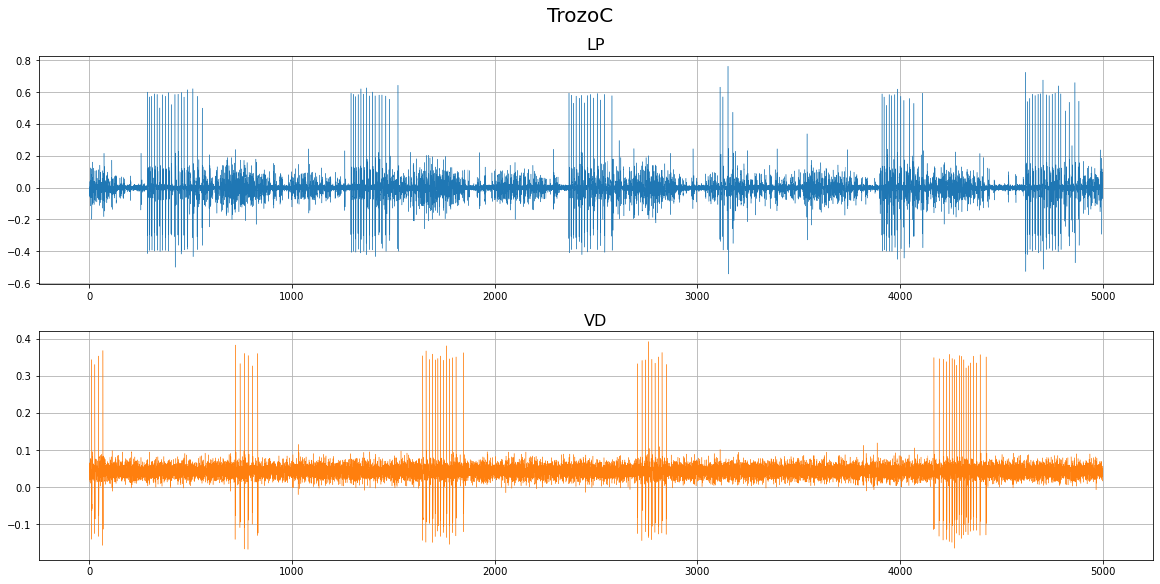

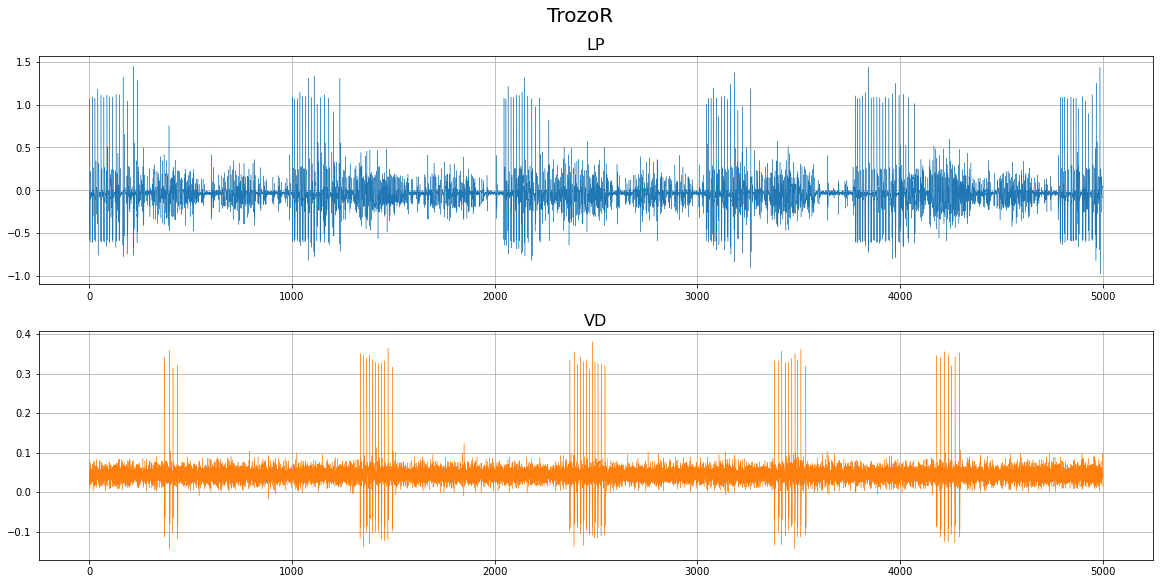

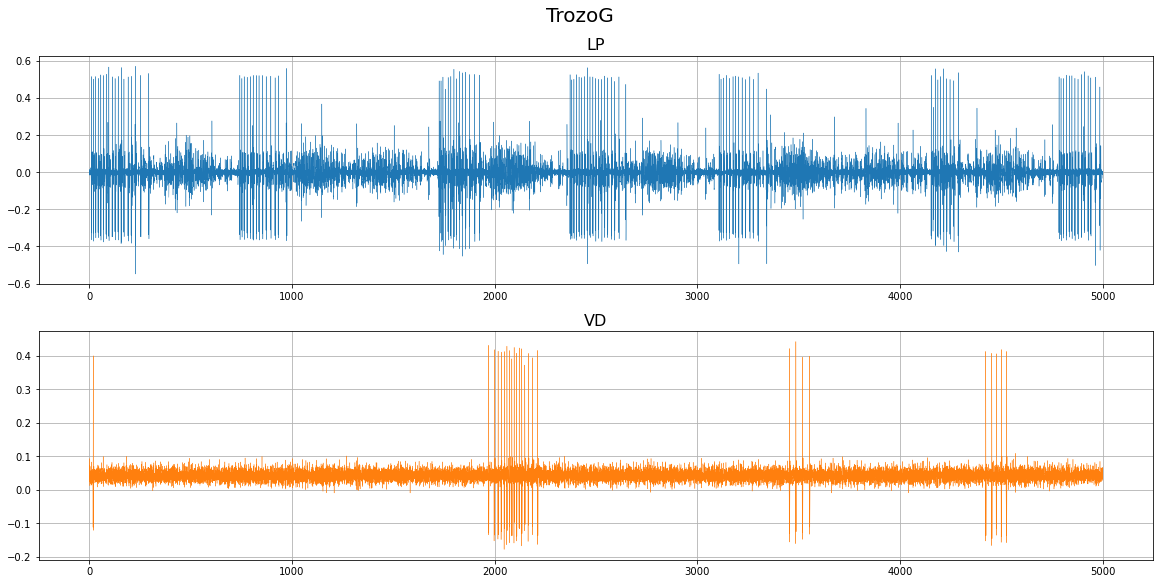

In [5]:
n = 50000
dt = 0.1
chunk_analysis(trozoC, 'TrozoC', n, dt)
chunk_analysis(trozoR, 'TrozoR', n, dt)
chunk_analysis(trozoG, 'TrozoG', n, dt)

# 3. Análisis de los datos a través de Spikes

## 3.2. Detección de Spikes

Como se ha comentado, para este primer análisis se ha decidido utilizar como evento de información los *spikes* (aumento rápido del potencial). Por tanto, el primer paso de nuestro análisis será definir un umbral que nos permita detectar estos eventos. 

El método utilizado para ello será una variante de un método estadístico utilizado para detectar datos atípico o *outliers*. A partir del cálculo de la media y la desviación típica de los datos, si un valor está a un cierto número de desviaciones típicas de la media, se considerará como un valor atípico. En estadística se utilizan un total de 3 desviaciones típicas de la media para detectar los outliers.

Sin embargo, al observar la distribución de nuestros datos, vemos que el rango intercuartílico (Q3 - Q1) es muy estrecho y este método detectaría un mayor número de datos atípicos. Por tanto, en nuestra versión implementada en **get_threshold** hemos decidido utilizar un total de 4.5 desviaciones estándar, esto es
$$
\begin{equation*}
    \mu \pm 4.5\sigma.
\end{equation*}
$$

________________ TrozoC ________________
                 LP            VD
count  1.984770e+07  1.984770e+07
mean  -2.253853e-08  4.385849e-02
std    8.214042e-02  3.287948e-02
min   -7.101440e-01 -2.170715e+00
25%   -2.288800e-02  3.295900e-02
50%    3.050000e-04  4.364000e-02
75%    2.410900e-02  5.401600e-02
max    9.344480e-01  1.351624e+00


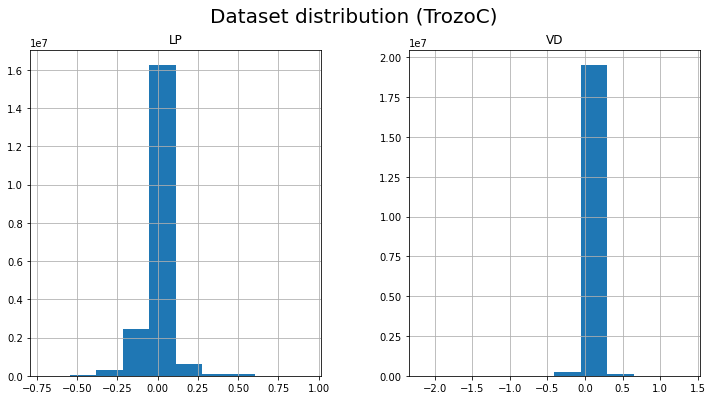

Threshold for each neuron (TrozoC):
LP    0.37
VD    0.20
dtype: float64
________________ TrozoG ________________
                 LP            VD
count  1.638400e+07  1.638400e+07
mean   1.782227e-11  4.330900e-02
std    8.109792e-02  3.337760e-02
min   -6.420900e-01 -3.088380e-01
25%   -2.624500e-02  3.326400e-02
50%    0.000000e+00  4.303000e-02
75%    2.441400e-02  5.310100e-02
max    9.265140e-01  5.520630e-01


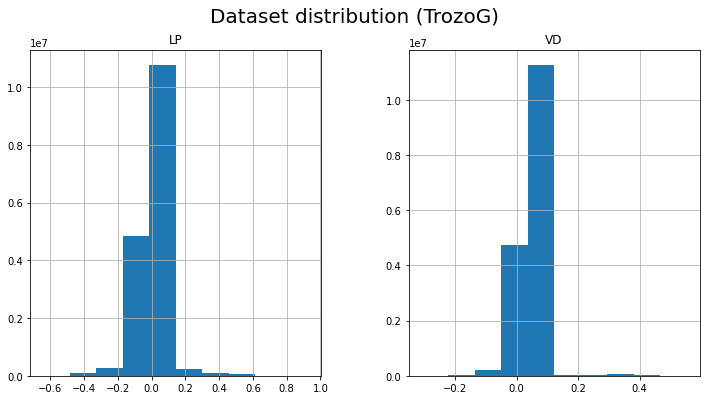

Threshold for each neuron (TrozoG):
LP    0.37
VD    0.20
dtype: float64
________________ TrozoR ________________
                 LP            VD
count  1.638400e+07  1.638400e+07
mean  -3.341000e-02  4.389221e-02
std    1.948664e-01  3.313382e-02
min   -1.328430e+00 -2.170715e+00
25%   -1.058960e-01  3.295900e-02
50%   -3.662100e-02  4.364000e-02
75%    1.770000e-02  5.432100e-02
max    1.992188e+00  1.351624e+00


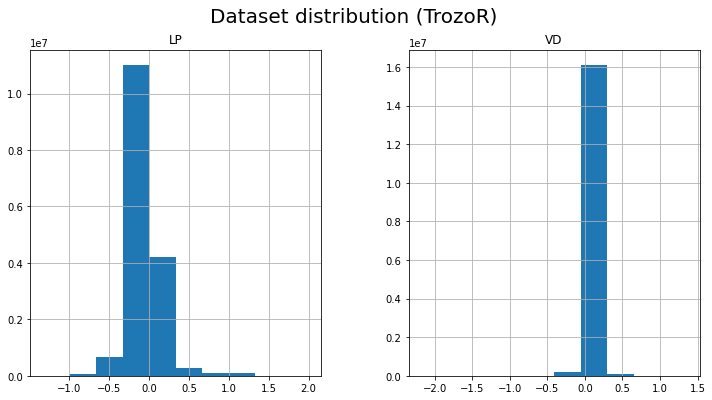

Threshold for each neuron (TrozoR):
LP    0.85
VD    0.20
dtype: float64


In [5]:
def get_threshold(df, precision=2):
    """
        returns threshold from the method described above.
        Args:
            df (Dataframe): dataframe to analyze (TrozoC, TrozoG or TrozoR)
            precision (int): number of decimals to round
    """
    r = df.mean() + 4.5*df.std()
    return np.round(r + 0.5 * 10**(-precision), precision)

def get_spikes(chunk, name):
    """
        returns and shows thresholds.
        Args:
            chunk (Dataframe): dataframe to analyze (TrozoC, TrozoG or TrozoR)
            name (str): name of chunk to analyze
    """
    print("________________ {0} ________________".format(name))
    print("{0}".format(chunk.describe()))
    histogram = chunk.hist(figsize = (12, 6))
    plt.suptitle('Dataset distribution ({0})'.format(name), fontsize=20)
    plt.show()
    
    threshold = get_threshold(chunk)
    print('Threshold for each neuron ({0}):'.format(name))
    print('{0}'.format(threshold))
    return threshold

thresholdC = get_spikes(trozoC, 'TrozoC')
thresholdG = get_spikes(trozoG, 'TrozoG')
thresholdR = get_spikes(trozoR, 'TrozoR')

Definidos los umbrales para cada neurona en cada etapa, utilizamos la propia función **find_peaks** de *scipy* que encuentra de manera eficiente todos los spikes de una señal que superen un umbral pasado por argumento y que se encuentren a una cierta distancia. En una primera versión de los spikes, asumiremos que la distancia mínima entre spikes puede ser mayor o igual a 1. Sin embargo, veremos que así se obtiene un gran número de spikes y en muchas ocasiones estaremos contabilizando spikes distintos que debido al umbral que hemos establecido pertenecen a un mismo aumento de potencial que se alarga en el tiempo.

________________ TrozoC ________________
Total events (LP): 31231
Total events (VD): 22335
________________ TrozoG ________________
Total events (LP): 26633
Total events (VD): 15662
________________ TrozoR ________________
Total events (LP): 24961
Total events (VD): 18674


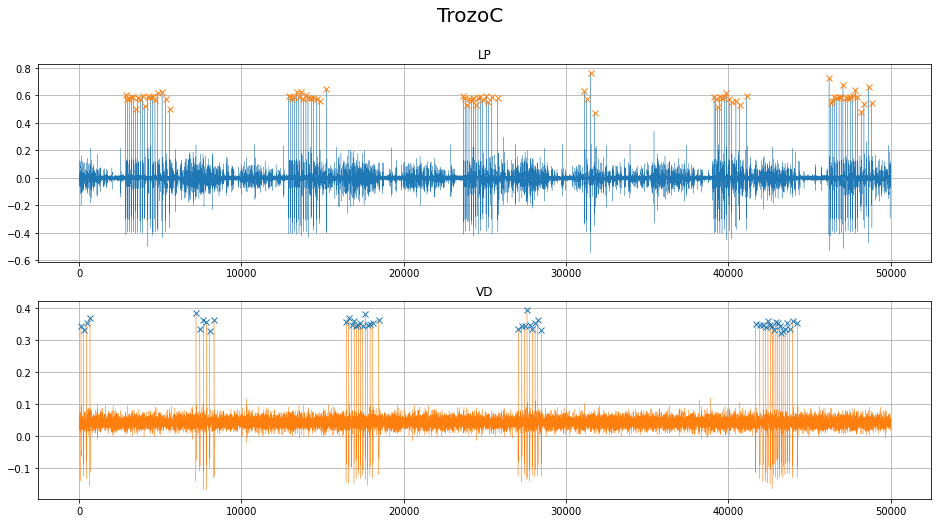

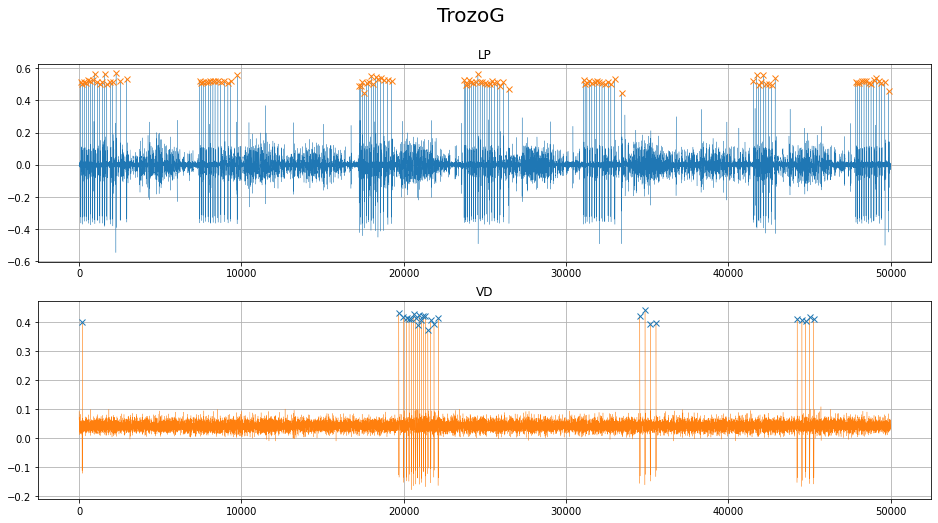

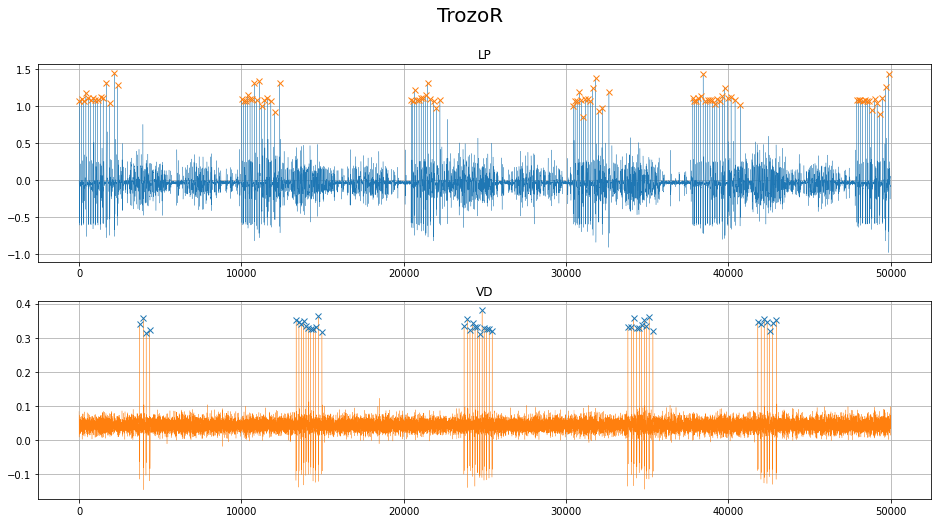

In [6]:
def find_events(chunk, name, threshold, distance=1, n=50000):
    """
        returns index of spikes found and show spikes.
        Args:
            chunk (Dataframe): dataframe to analyze (TrozoC, TrozoG or TrozoR)
            threshold (float): threshold of spikes
            distance (int): minimum distance between spikes
            name (str): name of chunk to analyze
            n (int): size of signal to show
    """

    print("________________ {0} ________________".format(name))
    lp_events, _ = find_peaks(chunk.LP[:n], threshold[0], distance = distance)
    vd_events, _ = find_peaks(chunk.VD[:n], threshold[1], distance = distance)
    
    t_lp,_ = find_peaks(chunk.LP, threshold[0],distance = distance)
    t_vd,_ = find_peaks(chunk.VD, threshold[1],distance = distance)
    print("Total events (LP): {0}".format(len(t_lp)))
    print("Total events (VD): {0}".format(len(t_vd)))
    
    fig, (ax1, ax2) = plt.subplots(2, 1)
    fig.set_size_inches(16, 8)
    fig.suptitle('{0}'.format(name), fontsize=20)

    ax1.plot(chunk.LP[:n], lw=0.3)
    ax1.plot(lp_events, chunk.LP[:n][lp_events], "x")
    ax1.set_title("LP")
    ax1.grid(True)

    ax2.plot(chunk.VD[:n],'tab:orange', lw=0.3)
    ax2.plot(vd_events, chunk.VD[:n][vd_events], "x")
    ax2.set_title("VD")
    ax2.grid(True)
    
    return t_lp, t_vd


lp_spikes_C, vd_spikes_C = find_events(trozoC, 'TrozoC', thresholdC)
lp_spikes_G, vd_spikes_G = find_events(trozoG, 'TrozoG', thresholdG)
lp_spikes_R, vd_spikes_R = find_events(trozoR, 'TrozoR', thresholdR)

A continuación, estudiaremos la distribución que siguen las distancias entre spikes con el fin de detectar aquellos spikes cuya distancia sea demasiado próxima y pueda tratarse del propio ruido de los datos y de nuestra elección de umbral. Para ello, mostraremos un resumen de las estadísticas de esta distribución: distancias mínimas, máximas, media, medianas, así como el quantil 0.0025, es decir, la distancia que deja el 0.25% de los datos a la izquierda.  

________________ TrozoC ________________
________ LP ________
Min: 3
Max: 22323
Mean: 635.3495036823567
Medium: 154.0
Q1: 24.80725
________ VD ________
Min: 4
Max: 29910
Mean: 888.3783469150175
Medium: 160.0
Q1: 17.1665
________________ TrozoG ________________
________ LP ________
Min: 4
Max: 14121
Mean: 614.9039876839892
Medium: 155.0
Q1: 24.65775
________ VD ________
Min: 2
Max: 21409
Mean: 1045.8287465679075
Medium: 191.0
Q1: 62.915
________________ TrozoR ________________
________ LP ________
Min: 40
Max: 23023
Mean: 656.3359375
Medium: 155.0
Q1: 41.23975
________ VD ________
Min: 4
Max: 29910
Mean: 877.213677502276
Medium: 159.0
Q1: 14.008000000000001


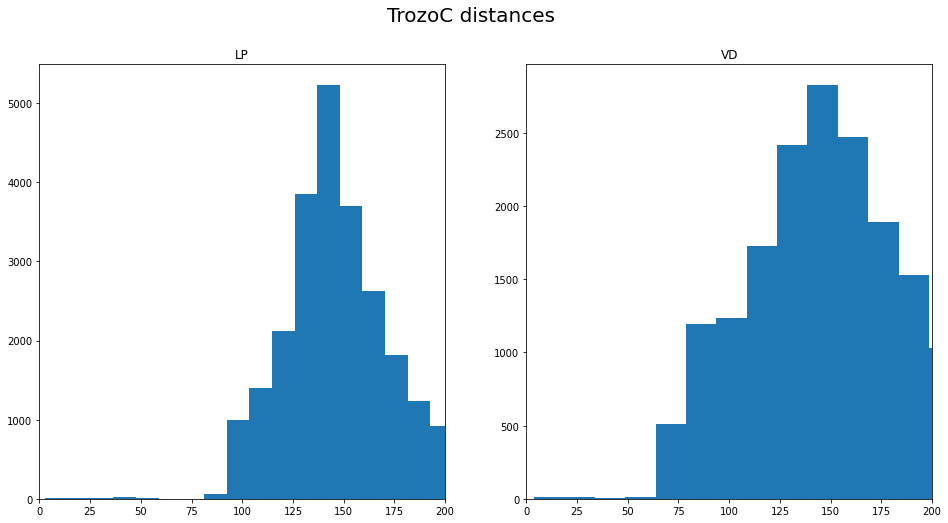

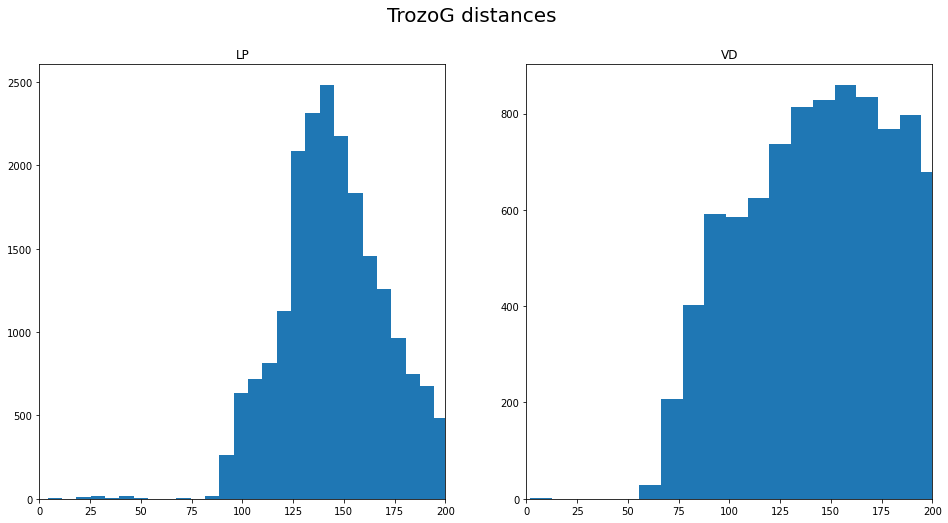

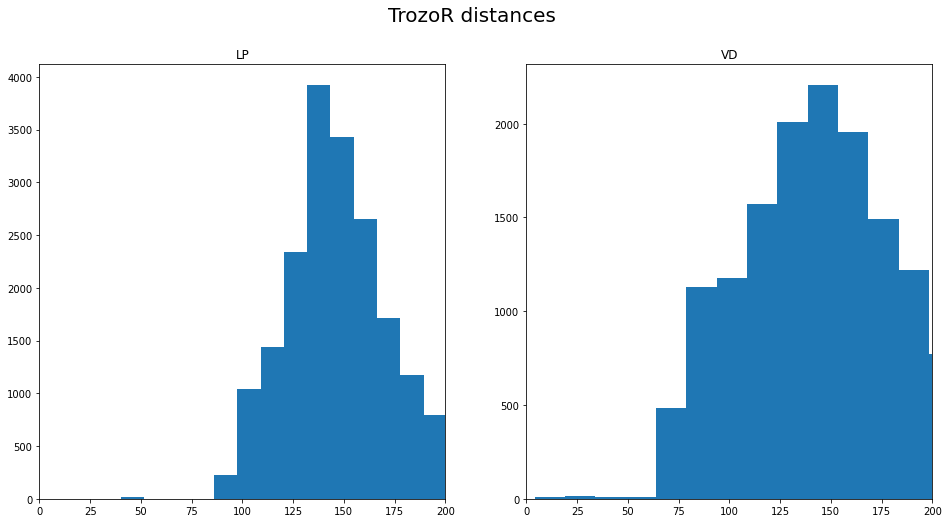

In [7]:
def distances_b_events(name, lp_events, vd_events, lmin,lmax):
    """
        show distance between spikes distribution
        Args:
            name (str): name of chunk to analyze
            lp_events (numpy): index of lp spikes found
            vd_events (numpy): index of vd spikes found
            lmin (int): lower limit of plot
            lmax (int): upper limit of plot

    """
        
    lp_distances = np.diff(lp_events)
    vd_distances = np.diff(vd_events)
    
    print("________________ {0} ________________".format(name))
    print("________ LP ________")
    print('Min: {0}'.format(np.amin(lp_distances)))
    print('Max: {0}'.format(np.amax(lp_distances)))
    print('Mean: {0}'.format(np.mean(lp_distances)))
    print('Medium: {0}'.format(np.median(lp_distances)))
    print('Q1: {0}'.format(np.quantile(lp_distances, 0.00025)))
    print("________ VD ________")
    print('Min: {0}'.format(np.amin(vd_distances)))
    print('Max: {0}'.format(np.amax(vd_distances)))
    print('Mean: {0}'.format(np.mean(vd_distances)))
    print('Medium: {0}'.format(np.median(vd_distances)))
    print('Q1: {0}'.format(np.quantile(vd_distances, 0.00025)))
    
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(16, 8)
    fig.suptitle('{0} distances'.format(name), fontsize=20)

    ax1.hist(lp_distances, bins=2000)
    ax1.set_xlim((lmin, lmax))
    ax1.set_title("LP")

    ax2.hist(vd_distances, bins=2000)
    ax2.set_title("VD")
    ax2.set_xlim((lmin, lmax))

distances_b_events('TrozoC', lp_spikes_C, vd_spikes_C, 0, 200)
distances_b_events('TrozoG', lp_spikes_G, vd_spikes_G, 0, 200)
distances_b_events('TrozoR', lp_spikes_R, vd_spikes_R, 0, 200)

La mayor distancia mínima encontrada es igual a 40 para la neurona LP en la etapa de recuperación y la menor distancia mínima encontrada entre spikes es igual a 2 para la neurona VD en la etapa de inyección de GABA. Este último valor es muy sospechoso, sobre todo teniendo en cuenta que utilizamos registros con un desfase temporal igual a 0.1. Para lidiar con el posible ruido en los datos y que no perjudique nuestro análisis de transmisión de información, se realiza un análisis de las distancias mínimas entre spikes para cada neurona en cada etapa cuando forzamos distintas distancias entre spikes en la detección de los mismos. 

In [8]:
distances = [1,2,3,4,5,6,7,8,9,10,11,12]
for distance in distances:
    c_lp = np.amin(np.diff(find_peaks(trozoC.LP, thresholdC[0], distance = distance)[0]))
    c_vd = np.amin(np.diff(find_peaks(trozoC.VD, thresholdC[1], distance = distance)[0]))

    g_lp = np.amin(np.diff(find_peaks(trozoG.LP, thresholdG[0], distance = distance)[0]))
    g_vd = np.amin(np.diff(find_peaks(trozoG.VD, thresholdG[1], distance = distance)[0]))

    r_lp = np.amin(np.diff(find_peaks(trozoR.LP, thresholdR[0], distance = distance)[0]))
    r_vd = np.amin(np.diff(find_peaks(trozoR.VD, thresholdR[1], distance = distance)[0]))
    
    print(f'Min distance between spikes with distance forced to {distance} = {min(c_lp,c_vd,g_lp,g_vd,r_lp,r_vd)}')

Min distance between spikes with distance forced to 1 = 2
Min distance between spikes with distance forced to 2 = 2
Min distance between spikes with distance forced to 3 = 3
Min distance between spikes with distance forced to 4 = 4
Min distance between spikes with distance forced to 5 = 5
Min distance between spikes with distance forced to 6 = 8
Min distance between spikes with distance forced to 7 = 8
Min distance between spikes with distance forced to 8 = 8
Min distance between spikes with distance forced to 9 = 9
Min distance between spikes with distance forced to 10 = 10
Min distance between spikes with distance forced to 11 = 16
Min distance between spikes with distance forced to 12 = 16


Vemos que cuando forzamos una distancia entre spikes entre 6 y 8, la distancia mínima entre spikes es igual a 8, lo que nos garantiza realizar un análisis de transmisión de información entre neuronas utilizando palabras de hasta 8 bits. Por tanto, para maximizar el tamaño de la ventana, hemos decidido utilizar una distancia entre spikes mínima igual a 8 a la hora de detectarlos.

A continuación se calculan el número total de spikes por neurona en cada etapa así como las distribuciones de las distancias entre spikes bajo las nuevas restricciones.

________________ TrozoC ________________
Total events (LP): 31226
Total events (VD): 22333
________________ TrozoG ________________
Total events (LP): 26630
Total events (VD): 15661
________________ TrozoR ________________
Total events (LP): 24961
Total events (VD): 18672


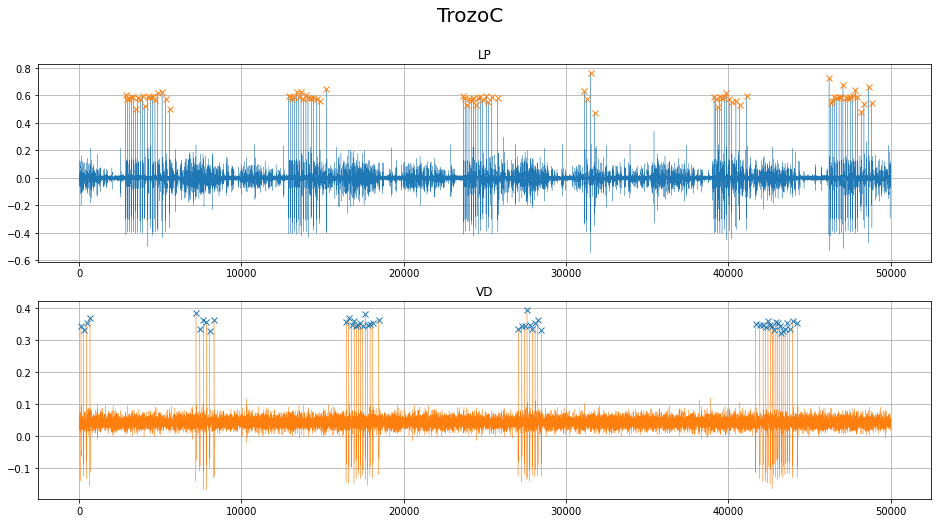

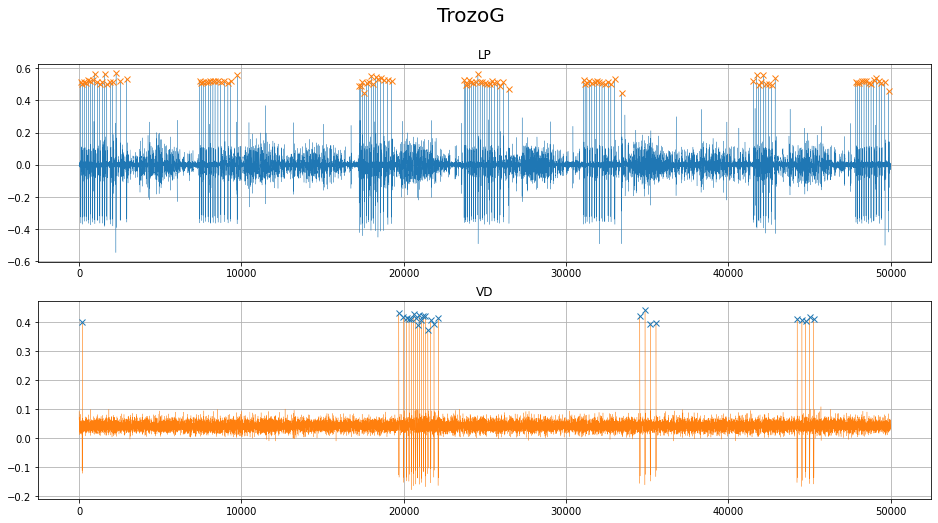

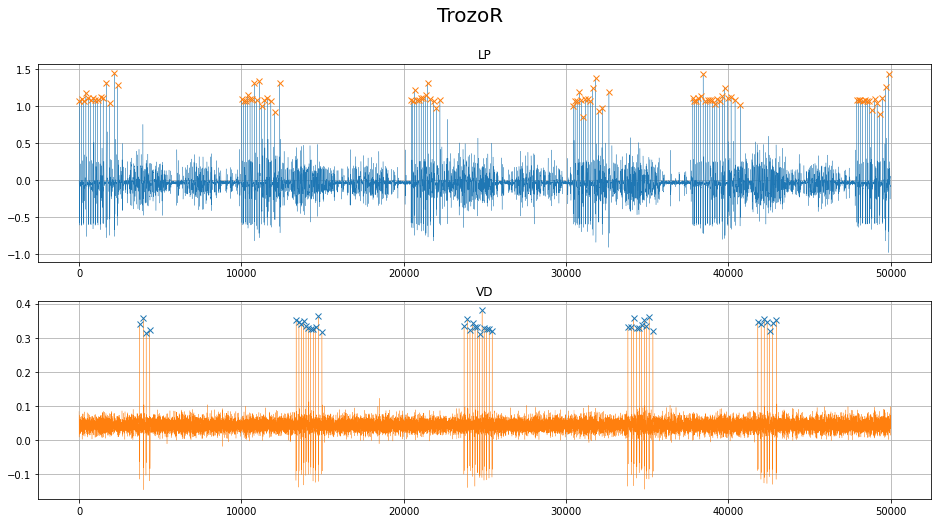

In [9]:
lp_spikes_C, vd_spikes_C = find_events(trozoC, 'TrozoC', thresholdC, 8)
lp_spikes_G, vd_spikes_G = find_events(trozoG, 'TrozoG', thresholdG, 8)
lp_spikes_R, vd_spikes_R = find_events(trozoR, 'TrozoR', thresholdR, 8)

________________ TrozoC ________________
________ LP ________
Min: 24
Max: 22323
Mean: 635.4512409927943
Medium: 154.0
Q1: 26.0
________ VD ________
Min: 8
Max: 29910
Mean: 888.457907934802
Medium: 160.0
Q1: 18.0
________________ TrozoG ________________
________ LP ________
Min: 20
Max: 14121
Mean: 614.973262232904
Medium: 155.0
Q1: 25.0
________ VD ________
Min: 60
Max: 21409
Mean: 1045.8955300127714
Medium: 191.0
Q1: 63.0
________________ TrozoR ________________
________ LP ________
Min: 40
Max: 23023
Mean: 656.3359375
Medium: 155.0
Q1: 41.23975
________ VD ________
Min: 8
Max: 29910
Mean: 877.3076428686198
Medium: 159.0
Q1: 18.0


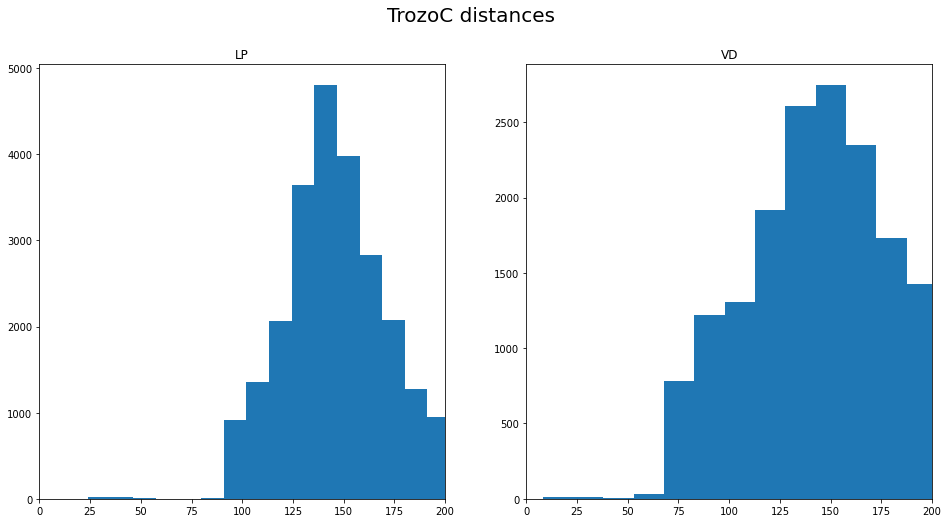

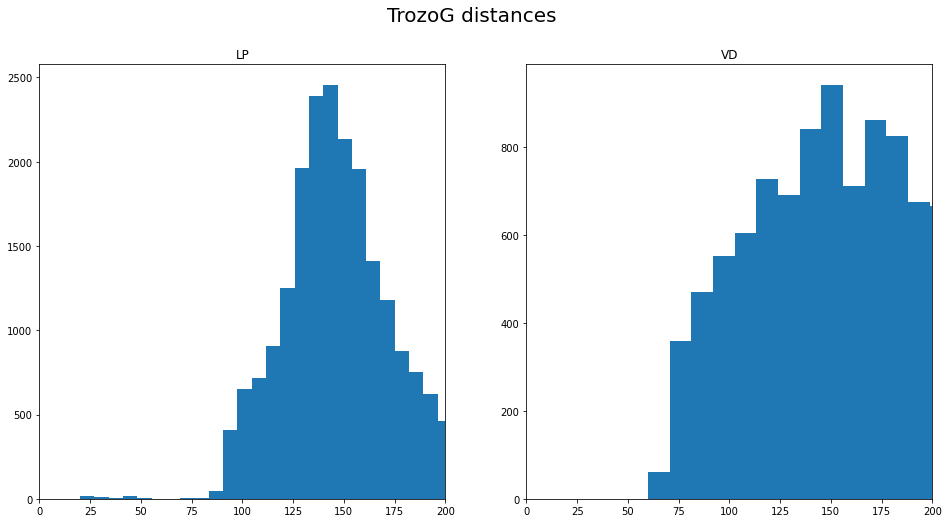

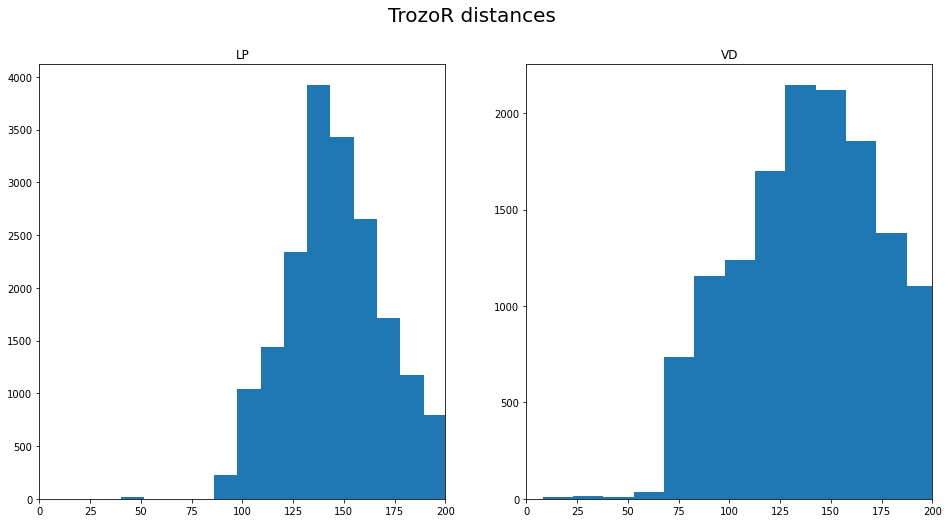

In [10]:
distances_b_events('TrozoC', lp_spikes_C, vd_spikes_C, 0, 200)
distances_b_events('TrozoG', lp_spikes_G, vd_spikes_G, 0, 200)
distances_b_events('TrozoR', lp_spikes_R, vd_spikes_R, 0, 200)

## 3.3. Codificación

Una vez bien definidos los eventos de nuestro análisis procedemos a discretizar las señales utilizando una codificación binaria (**discretize_by_speaks**), de modo que se asignará una valor igual a 1 aquellos valores de la señal clasificados como spikes y un valor de 0 para el resto de valores.


Se ilustra la nueva codificación de la señal (**show_discretize_spikes**).

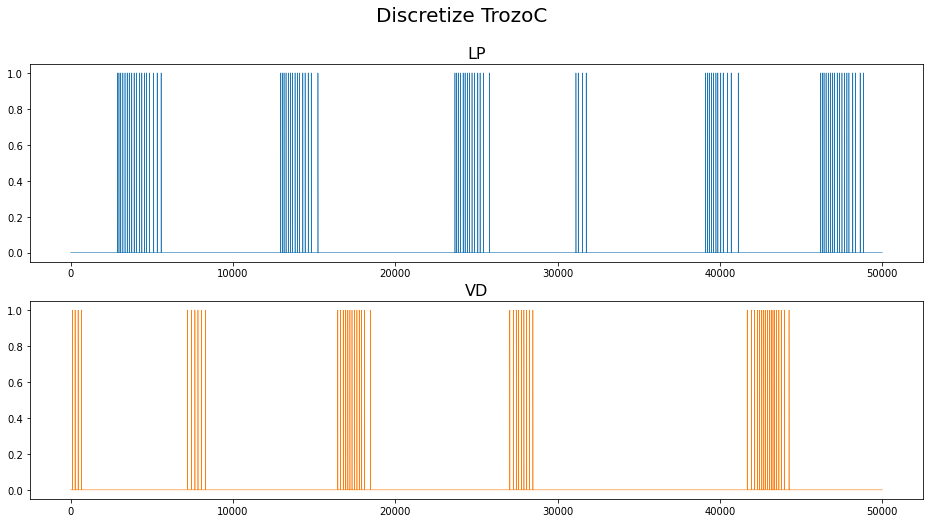

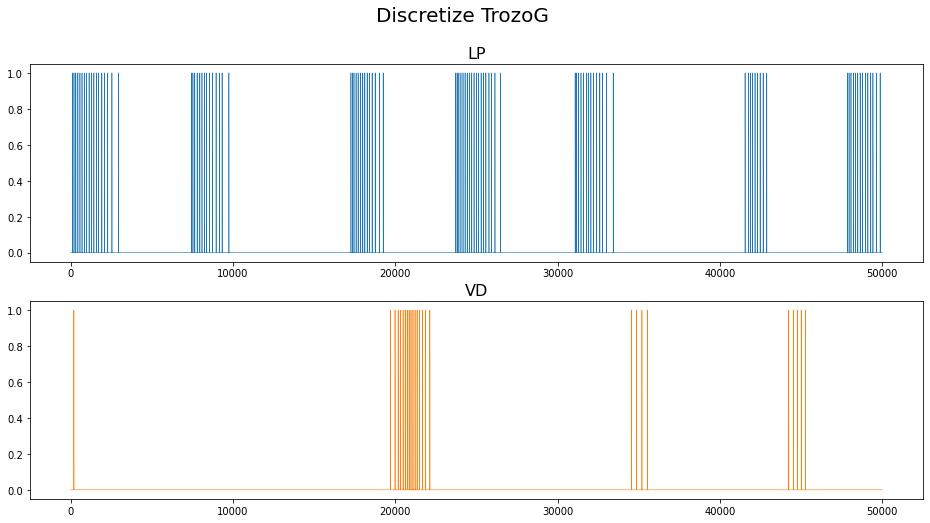

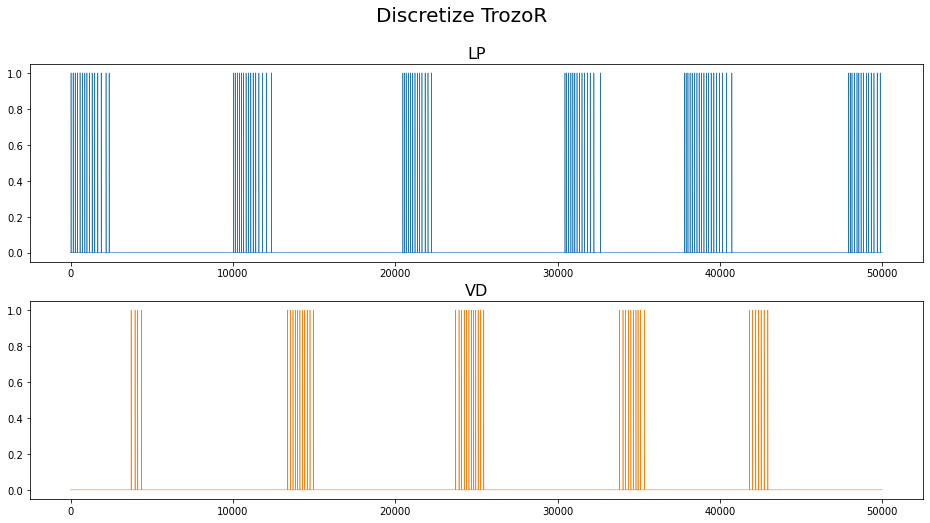

In [10]:
def discretize_by_speaks(chunk, lp_spikes, vd_spikes):
    """
        Binary encoding for spikes (spike = 1, other = 0)
        Args:
            chunk (Dataframe): chunk to analyze
            lp_spikes (numpy): index of lp spikes found
            vd_spikes (numpy): index of vd spikes found

    """

    chunk['LP_spikes'] = 0
    chunk.loc[lp_spikes, 'LP_spikes'] = 1
    chunk['VD_spikes'] = 0
    chunk.loc[vd_spikes, 'VD_spikes'] = 1
    return chunk

def show_discretize_spikes(chunk, name, n):
    """
        Show the first n binary encoding for spikes (spike = 1, other = 0)
        Args:
            chunk (Dataframe): chunk to analyze
            name (str): name of chunk to analyze
            n (int): n records to show

    """
    
    fig, (ax1, ax2) = plt.subplots(2, 1)
    fig.set_size_inches(16, 8)
    plt.suptitle('Discretize {0}'.format(name), fontsize=20)
    ax1.plot(chunk[f'LP_spikes'].iloc[:n],lw=0.6)
    ax1.set_title("LP", fontsize=16)
    ax2.plot(chunk[f'VD_spikes'].iloc[:n],'tab:orange',lw=0.6)
    ax2.set_title("VD", fontsize=16)


trozoC = discretize_by_speaks(trozoC, lp_spikes_C, vd_spikes_C)
show_discretize_spikes(trozoC, 'TrozoC', 50000)

trozoG = discretize_by_speaks(trozoG, lp_spikes_G, vd_spikes_G)
show_discretize_spikes(trozoG, 'TrozoG', 50000)

trozoR = discretize_by_speaks(trozoR, lp_spikes_R, vd_spikes_R)
show_discretize_spikes(trozoR, 'TrozoR', 50000)

## 3.4. Tamaño de ventana

En la codificación anterior, asumíamos un tamaño de ventana fijo igual a 1. Sin embargo, nos interesa maximizar el tamaño de la ventana de modo que no se obtenga más de un spike en la ventana. Con este objetivo en mente, calcularemos la tasa de error al variar el tamaño de la ventana (**get_errors_rate** y **get_errors_rate_per_neuron**).

In [11]:
def get_errors_rate(signal, bin_size):
    """
        Get error rate for a signal varying the bin size
        Args:
            signal (numpy): signal to analyze
            bin_size ([int]): array with bin sizes to calculate error rate
    """

    errors_rate = []
    for nbin in bin_size:
        bins_spikes = view_as_windows(signal, window_shape=nbin, step=nbin).sum(axis=1)
        errors_rate.append((bins_spikes>1).sum()/len(bins_spikes))
    return np.array(errors_rate)

def get_errors_rate_per_neuron(chunk, coding, name, bin_size):
    """
        Get error rate for each signal LP and VD varying the bin size
        Args:
            chunk (Dataframe): chunk to analyze
            coding (str): kind of events
            name (str): name of chunk to analyze
            bin_size ([int]): array with bin sizes to calculate error rate
    """
    lp_errors = get_errors_rate(np.array(chunk[f'LP_{coding}']),bin_size)
    vd_errors = get_errors_rate(np.array(chunk[f'VD_{coding}']),bin_size)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
    fig.set_size_inches(16, 8)
    plt.suptitle('Error rate per bin size ({0})'.format(name), fontsize=20)
    ax1.plot(bin_size, lp_errors)
    ax1.set_title("LP", fontsize=16)
    ax2.plot(bin_size, vd_errors)
    ax2.set_title("VD", fontsize=16)
    
    return lp_errors, vd_errors

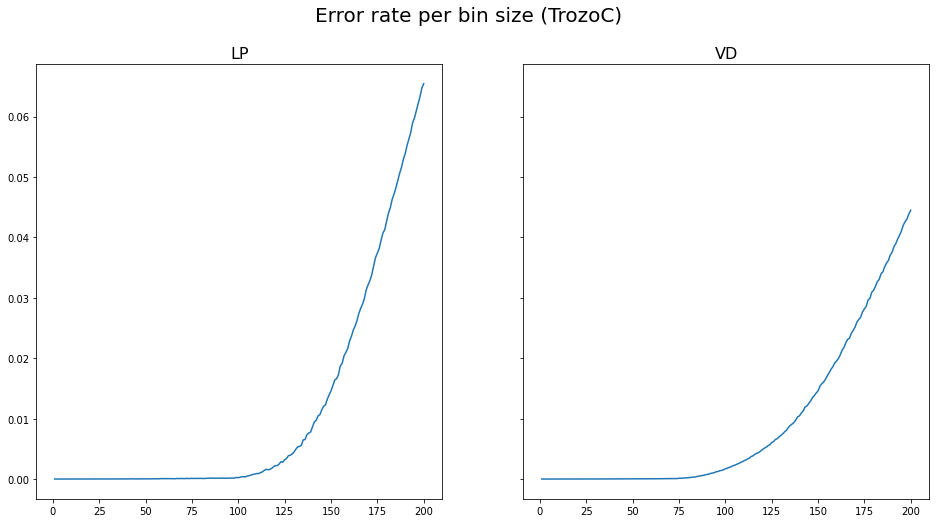

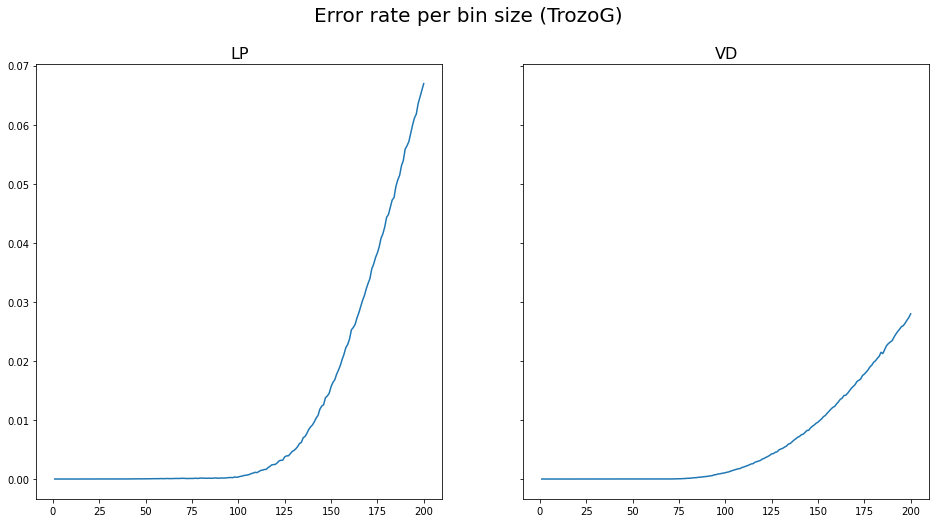

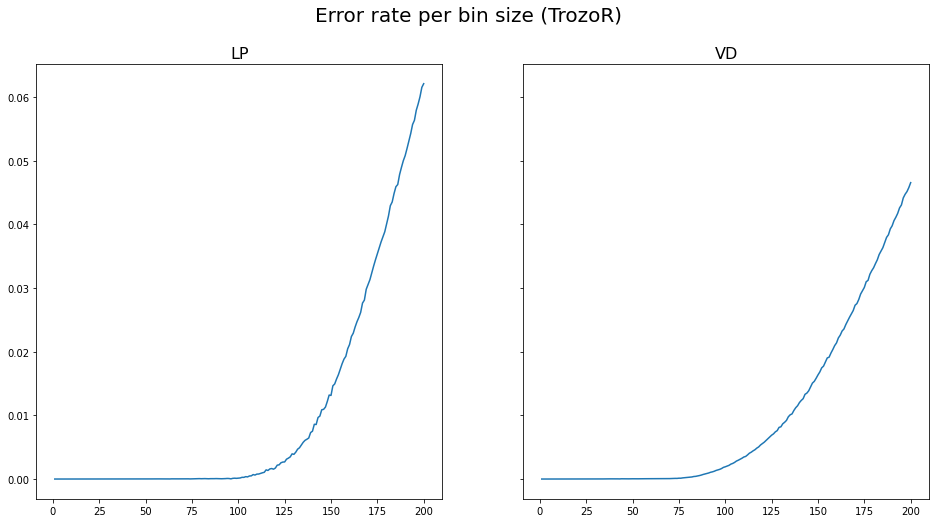

In [12]:
lp_errors_C, vd_errors_C = get_errors_rate_per_neuron(trozoC, 'spikes', 'TrozoC', range(1,201))
lp_errors_G, vd_errors_G = get_errors_rate_per_neuron(trozoG, 'spikes', 'TrozoG', range(1,201))
lp_errors_R, vd_errors_R = get_errors_rate_per_neuron(trozoR, 'spikes', 'TrozoR', range(1,201))

Para tamaños de ventana fijos, en todas las etapas, las neuronas LP y VD comienzan a presentar un mayor número de errores (presentan más de un spike por ventana) cuando se utilizan tamaños aproximadamente superiores a 150. El error obtenido al aumentar el tamaño por encima de 150 es mayor que el 1%. 

## 3.5. Cálculo de la entropía y la información mutua


El objetivo final del análisis de las señales en las distintas etapas es estudiar la transmisión de información entre las neuronas LP y VD. Para ello realizaremos una segunda codificación que consiste en la suma de los spikes por ventana para los distintos tamaños de ventana. 

Primero implementaremos una serie de funciones que permitan realizar esta segunda codificación, así como convertir la información en palabras de distintos bits. En segundo lugar se implementarán las funciones necesarias para calcular la entropía y la información mutua de las señales a partir del cálculo de sus probabilidades individuales y conjuntas.

Antes de continuar con la implementación de las funciones comentadas arriba, recordemos las características de cada una de las medidas de información que utilizaremos en el análisis: 

Sean $X,Y$ dos variables aleatorias y sean $x\in X$ y $y\in Y$ con $p(x)=P(X=x)$ y $p(y)=P(Y=y)$, se define la información mutua de X e Y como 

\begin{equation*}
    MI(X,Y) = \sum_{x\in X}\sum_{y\in Y}p(x,y)I(x,y),
\end{equation*}
con $p(x,y)=P(X=x, Y=y)$,
\begin{equation*}
    I(x,y)=\log_2\left(\frac{p(x|y)}{p(x)}\right)
\end{equation*}
y
\begin{equation*}
    p(x|y)=\frac{p(x,y)}{p(y)}.
\end{equation*}


Por su parte, la entropía de la variable $X$ y la variable $Y$ se define como

\begin{equation*}
S(X)=-\sum_{x\in X}p(x)\log_2\left(p(x)\right)
\end{equation*}
y
\begin{equation*}
S(Y)=-\sum_{y\in Y}p(y)\log_2\left(p(y)\right)
\end{equation*}
respectivamente.

El cálculo de la transmisión de información de una variable $X$ a una variable $Y$ viene dado por la fórmula 

\begin{equation*}
T(X\rightarrow Y) = \frac{MI}{S(X)}.
\end{equation*}
Para estudiar la transmisión de información de la variable $Y$ a la variable $X$ se utiliza

\begin{equation*}
T(Y\rightarrow X) = \frac{MI}{S(Y)}.
\end{equation*}



In [13]:
def to_words(signal, nbits, nsteps):
    """
        Convert a numpy array of int to a numpy array of string with the word codification
        Args:
            signal (Numpy): numpy array of int
            nbits (int): size of word
            nsteps (int): 1 to overlapping words, nbits to fix words
    """
    
    if nbits == 1:
        return np.array(list(map(str,signal)))
    else:
        signal_bin = view_as_windows(np.array(signal), window_shape=nbits, step=nsteps)
        return np.array([''.join(map(str,bins)) for bins in signal_bin])

def prob(x): # x : np of str (words)
    """
        Calculate the probability of each word
        Args:
            x (numpy array): signal with words information
    """
    
    keys, counts = np.unique(x, return_counts=True)
    return dict(zip(keys,counts/len(x)))

def joint_prob(x, y):  # x,y : np of str (words)
    """
        Calculate the joint probability between two signals
        Args:
            x (numpy array): x signal with words information
            y (numpy array): y signal with words information
    """
    
    xy = list(map('|'.join,zip(x, y)))
    keys, counts = np.unique(xy, return_counts=True)
    return dict(zip(keys,counts/len(x)))

def entropy(x): # x : dict of probabilities
    """
        Calculate the entropy of a signal
        Args:
            x (numpy array): x signal with words information
    """
    
    return - np.sum([w * np.log2(w) for w in x.values()])
    
def MI(x, y): # x,y : np of str (words)
    """
        Calculate the mutual information between two signals
        Args:
            x (numpy array): x signal with words information
            y (numpy array): y signal with words information
    """
    
    px, py, pxy = prob(x),prob(y),joint_prob(x,y)
    ex, ey = entropy(px), entropy(py)
    mi=0
    for k in pxy:
        kx, ky = k.split('|')
        mi += pxy[k] * np.log2(pxy[k]/(px[kx] * py[ky]))
    return mi, ex, ey

In [14]:
def show_probabilities(chunk, coding, nbits, name):
    """
        Show the information of the signals
        Args:
            chunk (Dataframe): chunk to analyze
            coding (str): kind of events
            nbits (str): size of words
            name (str): name of chunk to analyze
    """
    
    print("________________ {0} ________________".format(name))
    lp_words = to_words(chunk[f'LP_{coding}'], nbits, nbits)
    vd_words = to_words(chunk[f'VD_{coding}'], nbits, nbits)
    prob_lp,prob_vd = prob(lp_words),prob(vd_words)
    joint_prob_lpvd = joint_prob(lp_words,vd_words)
    mi, e_clp, e_cvd = MI(lp_words,vd_words)
    print("Probabilidades LP con {0} bit: \n{1}".format(nbits, json.dumps(prob_lp,sort_keys=True, indent=2)))
    print("\nProbabilidades VD con {0} bit: \n{1}".format(nbits, json.dumps(prob_vd,sort_keys=True, indent=2)))
    print("\nProbabilidades Conjuntas LP y VD con {0} bit: \n{1}".format(nbits, json.dumps(joint_prob_lpvd,sort_keys=True, indent=2)))
    print("\nEntropía LP con {0} bit: {1}".format(nbits, e_clp))
    print("\nEntropía VD con {0} bit: {1}".format(nbits, e_cvd))
    print("\nInformación Mutua LP y VD con {0} bit: {1}".format(nbits, mi))

A continuación, se muestra un ejemplo de la información obtenida (probabilidaes conjuntas, entropía e información mutua) para las señales LP y VD en la etapa de Control utilizando un tamaño de ventana igual a 1, y un tamaño de palabra igual a 2.

In [18]:
show_probabilities(chunk = trozoC, coding = 'spikes', nbits = 2, name = 'TrozoC')

________________ TrozoC ________________
Probabilidades LP con 2 bit: 
{
  "00": 0.9968534389375091,
  "01": 0.001570862115005769,
  "10": 0.001575698947485099
}

Probabilidades VD con 2 bit: 
{
  "00": 0.9977495629216484,
  "01": 0.0011249666208175255,
  "10": 0.0011254704575341223
}

Probabilidades Conjuntas LP y VD con 2 bit: 
{
  "00|00": 0.9946032033938441,
  "00|01": 0.0011247650861308867,
  "00|10": 0.0011254704575341223,
  "01|00": 0.0015707613476624496,
  "01|01": 1.0076734331937706e-07,
  "10|00": 0.0015755981801417796,
  "10|01": 1.0076734331937706e-07
}

Entropía LP con 2 bit: 0.03383317609372063

Entropía VD con 2 bit: 0.025287372660367055

Información Mutua LP y VD con 2 bit: 9.118029643424215e-06


A continuación se define la función **compute_signal_by_bins** encargada de dividir las señales de cada etapa en ventanas de distintos tamaños  devolviendo un diccionario que asigna a cada tamaño de la ventana la nueva codificación de la señal ese tamaño de ventana. Se define también la función **compute_information** encargada de codificar las señales utilizando palabras de distintos bits y calcular las distintas medidas de información para cada tamaño de palabra y cada tamaño de ventana. Esta función asigna a cada tamaño de palabra, los cálculos de información variando el tamaño de la ventana de la señal. Se utilizan diccionarios para optimizar el acceso a los datos. La estructura del diccionario resultante es la siguiente:

```
{   
    "1": {"mi": [], # Mutual Information for each bin size
            "elp": [], # LP entropy for each bin size
            "evd": [], # VD entropy for each bin size 
            "ti_lp_vd": [], # LP-->VD transmission for each bin size 
            "ti_vd_lp": [] # VD-->LP transmission for each bin size
           },
    "2": {...}
}
```

In [15]:
def compute_signal_by_bins(bin_size, chunk, coding):
    """
        Compute signal by bins of a given bin_size returning a diccionary with new signal codification for each key (bin size)
        Args:
            chunk (Dataframe): chunk to analyze
            bin_size ([int]): list of bin size to compute
            coding (str): kind of events
    """
    
    lp_bins, vd_bins = {}, {}
    for nbins in bin_size:
        lp_bins[nbins] = view_as_windows(np.array(chunk[f'LP_{coding}']), window_shape=nbins, step=nbins).sum(axis=1)
        vd_bins[nbins] = view_as_windows(np.array(chunk[f'VD_{coding}']), window_shape=nbins, step=nbins).sum(axis=1)
    
    return lp_bins, vd_bins

def compute_information(word_size, bin_size, lp_bins, vd_bins, fix):
    """
        Compute signal information by word size 
        Args:
            word_size ([int]): list of word size to compute
            bin_size ([int]):  list of bin size to compute
            lp_bins (diccionary): diccionary with signal of different bin size
            vd_bins (diccionary): diccionary with signal of different bin size
            fix (boolean): true for fixed words, false for overlapping words 
    """
    information = {}
    for nbits in word_size:
        mi_l, elp_l, evd_l = [], [], []
        for nbins in bin_size:
            if fix == True:
                lp_words = to_words(lp_bins[nbins], nbits, nbits)
                vd_words = to_words(vd_bins[nbins], nbits, nbits)
            else:
                lp_words = to_words(lp_bins[nbins], nbits, 1)
                vd_words = to_words(vd_bins[nbins], nbits, 1)
            m_i, e_lp, e_vd = MI(lp_words,vd_words)
            mi_l.append(m_i)
            elp_l.append(e_lp)
            evd_l.append(e_vd)
        information[nbits] = {'mi': np.array(mi_l),'elp': np.array(elp_l),'evd': np.array(evd_l), 'ti_lp_vd':np.array(mi_l)/np.array(elp_l), 'ti_vd_lp':np.array(mi_l)/np.array(evd_l)}
    return information

In [17]:
bin_size = range(1,151)
lp_bins_C, vd_bins_C = compute_signal_by_bins(bin_size, chunk = trozoC, coding = 'spikes')
lp_bins_G, vd_bins_G = compute_signal_by_bins(bin_size, chunk = trozoG, coding = 'spikes')
lp_bins_R, vd_bins_R = compute_signal_by_bins(bin_size, chunk = trozoR, coding = 'spikes')

### 3.5.1. Utilizando palabras fijas

Se calculan las medidas de información cuando el tamaño de palabra es fijo. Se calculará para cada tamaño de palabra (desde 1 bit hasta 8 bits inclusive) las medidas de información obtenidas cuando el tamaño de ventana varía desde 1 hasta 150 inclusive. Recordemos que a partir de 150, la tasa de error aumentaba a más de 1%. 

In [18]:
word_size = range(1,9)
information_C = compute_information(word_size, bin_size, lp_bins_C, vd_bins_C, True)
information_G = compute_information(word_size, bin_size, lp_bins_G, vd_bins_G, True)
information_R = compute_information(word_size, bin_size, lp_bins_R, vd_bins_R, True)

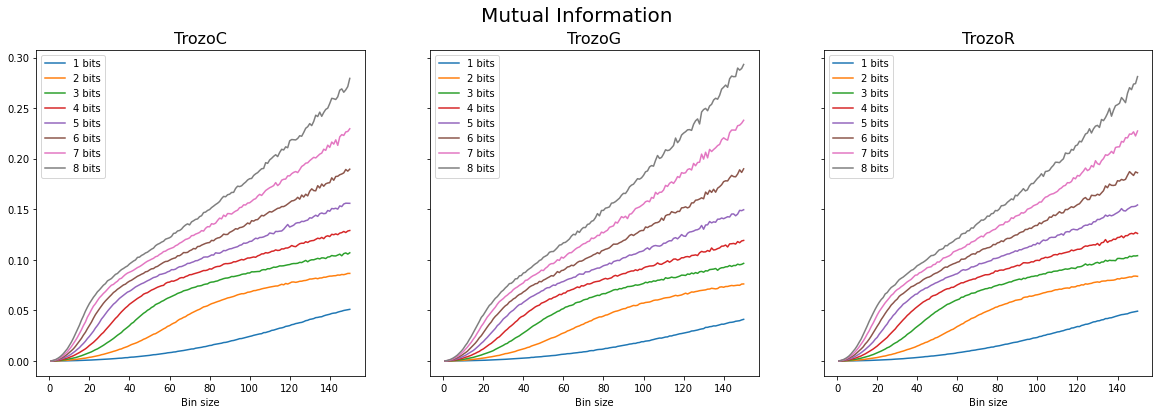

In [19]:
def plot_mutual_information(information_C, information_G, information_R, word_size, bin_size):
    """
        Plot mutual information for different bin size and by word size 
        Args:
            information_C (diccionary): Dict with mutual information
            information_G (diccionary): Dict with mutual information
            information_R (diccionary): Dict with mutual information 
            word_size ([int]): list of words size
            bin_size ([int]): list of bins size
    """

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True)
    fig.set_size_inches(20, 6)
    plt.suptitle(f'Mutual Information', fontsize=20)
    

    for nbits in word_size:
        ax1.plot(bin_size, information_C[nbits]['mi'], label = f"{nbits} bits")
    ax1.set_title("TrozoC", fontsize=16)
    ax1.set_xlabel("Bin size")
    ax1.legend()

    for nbits in word_size:
        ax2.plot(bin_size, information_G[nbits]['mi'], label = f"{nbits} bits")
    ax2.set_title("TrozoG", fontsize=16)
    ax2.set_xlabel("Bin size")
    ax2.legend()

    for nbits in word_size:
        ax3.plot(bin_size, information_R[nbits]['mi'], label = f"{nbits} bits")
    ax3.set_title("TrozoR", fontsize=16)
    ax3.set_xlabel("Bin size")
    ax3.legend()
    
    plt.show()
    
plot_mutual_information(information_C, information_G, information_R, word_size, bin_size)

#### Información mutua

Se analiza la información mutua de las neuronas LP y VD en las distintas etapas para cada tamaño de palabra mediante la variación de esta información para distintos tamaños de ventana.

Para todas las etapas se ve claramente que la información mutua entre las neuronas LP y VD aumenta al aumentar el tamaño de ventana, ya que se reducen la probabilidades de obtener 0's en la señal. 

Además, la mayor información mutua se obtiene cuando se utilizan palabras de 8 bits y la información mutua al aumentar el tamaño de ventana crece con más velocidad.

Por último, si comparamos la información mutua utilizando palabras de 8 bits en las distintas etapas, vemos que para la etapa de inyección de GABA, la información mutua es superior.

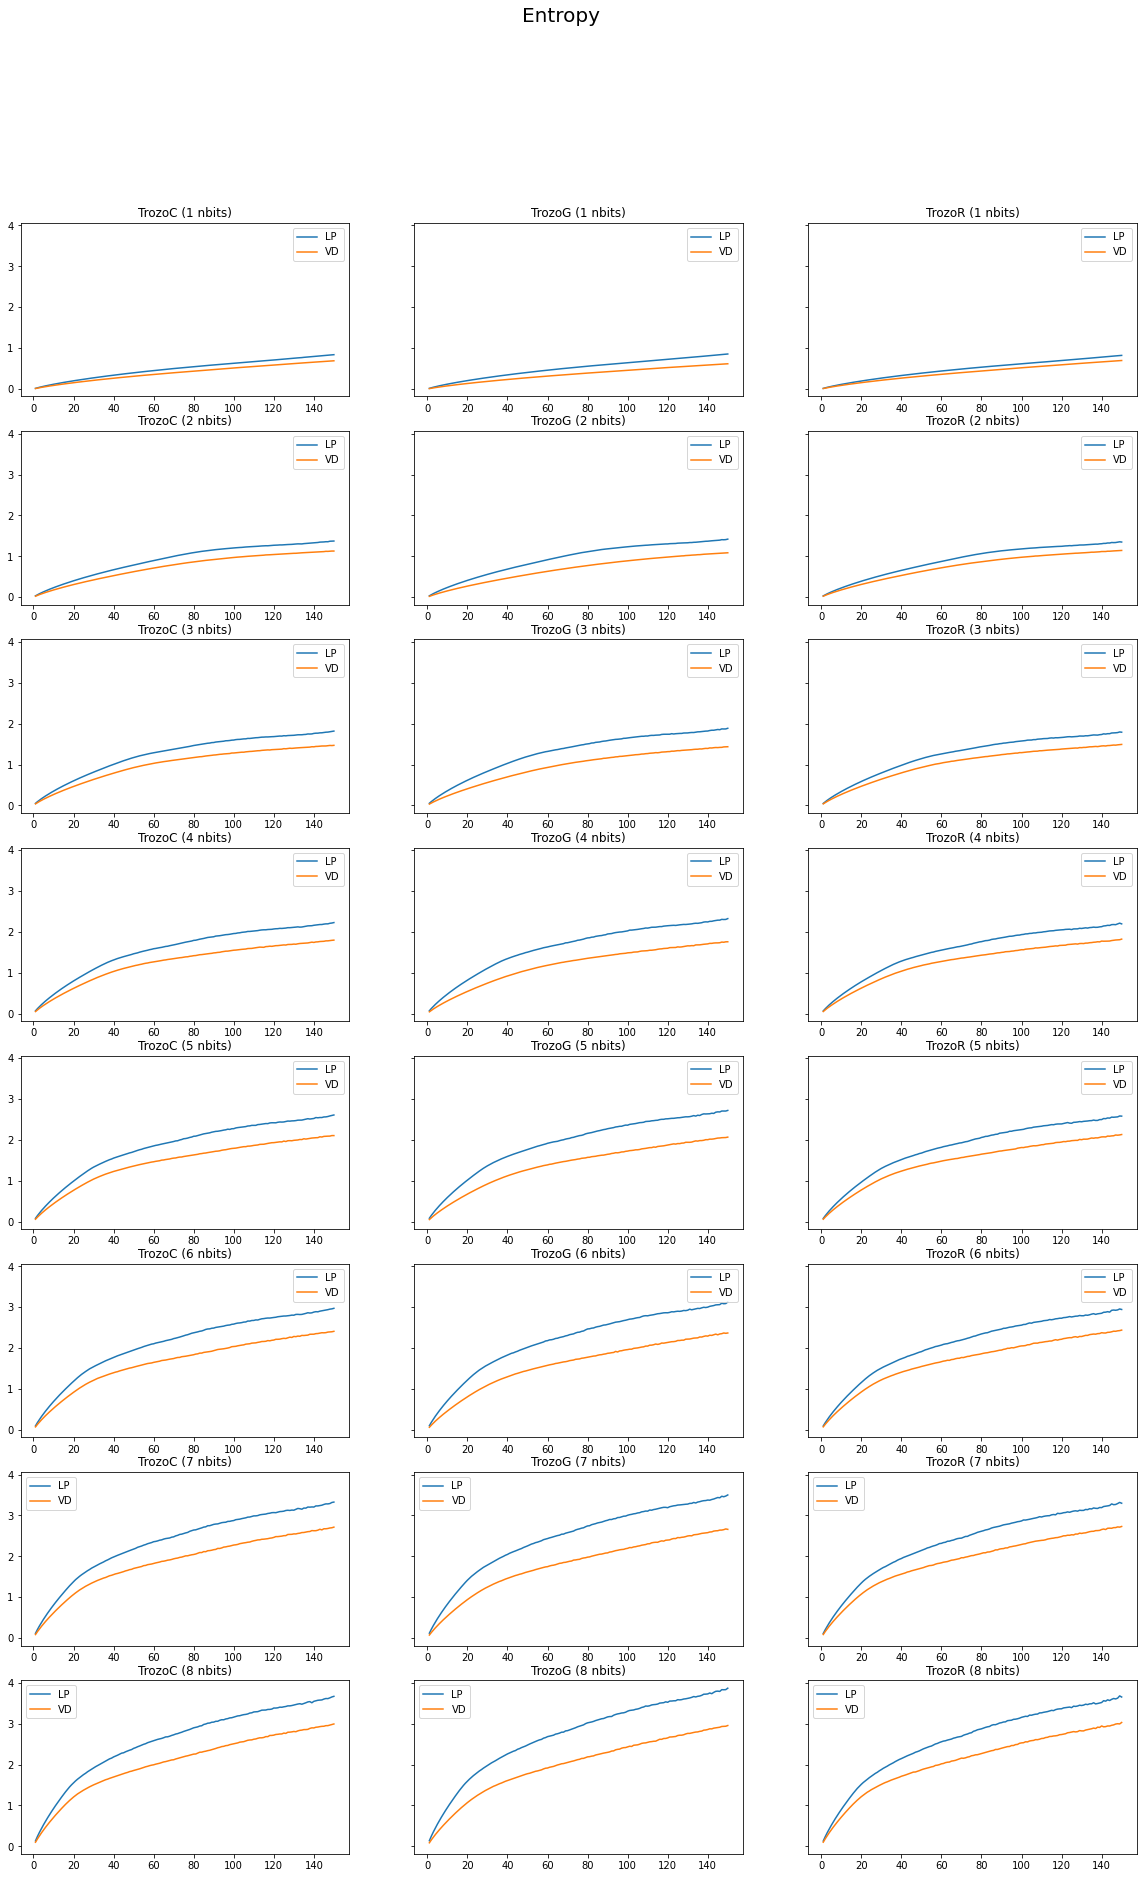

In [20]:
def plot_entropia(informationC,informationG,informationR, word_size, bin_size):
    """
        Plot entropy for different bin size and by word size 
        Args:
            information_C (diccionary): Dict with mutual information
            information_G (diccionary): Dict with mutual information
            information_R (diccionary): Dict with mutual information 
            word_size ([int]): list of words size
            bin_size ([int]): list of bins size
    """
    fig, axes = plt.subplots(len(word_size), 3, figsize=(20, 30), sharey=True)
    plt.suptitle(f'Entropy', fontsize=20)
    for nbits,row in enumerate(axes):
        row[0].plot(bin_size,informationC[nbits+1]['elp'],label='LP')
        row[0].plot(bin_size,informationC[nbits+1]['evd'],label='VD')
        row[0].set_title(f"TrozoC ({nbits+1} nbits)")
        row[0].legend()

        row[1].plot(bin_size,informationG[nbits+1]['elp'],label='LP')
        row[1].plot(bin_size,informationG[nbits+1]['evd'],label='VD')
        row[1].set_title(f"TrozoG ({nbits+1} nbits)")
        row[1].legend()

        row[2].plot(bin_size,informationR[nbits+1]['elp'],label='LP')
        row[2].plot(bin_size,informationR[nbits+1]['evd'],label='VD')
        row[2].set_title(f"TrozoR ({nbits+1} nbits)")
        row[2].legend()

    plt.show()
    
plot_entropia(information_C, information_G, information_R, word_size, bin_size)

#### Entropía

A continuación, se analiza la entropía de las neuronas LP y VD en las distintas etapas mediante la variación de la entropía al aumentar el tamaño de ventana para cada tamaño de palabra.

En todas las etapas y para todos los tamaños de palabra utilizados se ve claramente que la entropía de la neurona LP es mayor que la entropía de la neurona VD y que, aunque en todas las etapas, los valores de la entropía son muy similares, destaca la entropía de la etapa de inyección de GABA. 

Además, la entropía de ambas neuronas es muy superior cuando se utilizan palabras de 8 bits que cuando se utilizan palabras más cortas, ya que aumentando el tamaño de palabra se consiguen más combinaciones de palabras y por tanto, las probabilidades se reparten. 

Por último, cabe resaltar que la entropía de ambas neuronas aumenta al aumentar el tamaño de ventana. Esto se debe a que al utilizar tamaños de ventana pequeños, la probabilidad de obtener cadenas de 0's es muy alta, mientras que al aumentar el tamaño de ventana, se disminuye el número de ceros en las señales pero se mantiene el número de apariciones del resto de las palabras. Así, disminuye la probabilidad de la palabra de 0's pero aumenta proporcionalmente la probabilidad del resto de palabras, lo que supone un aumento de la entropía.

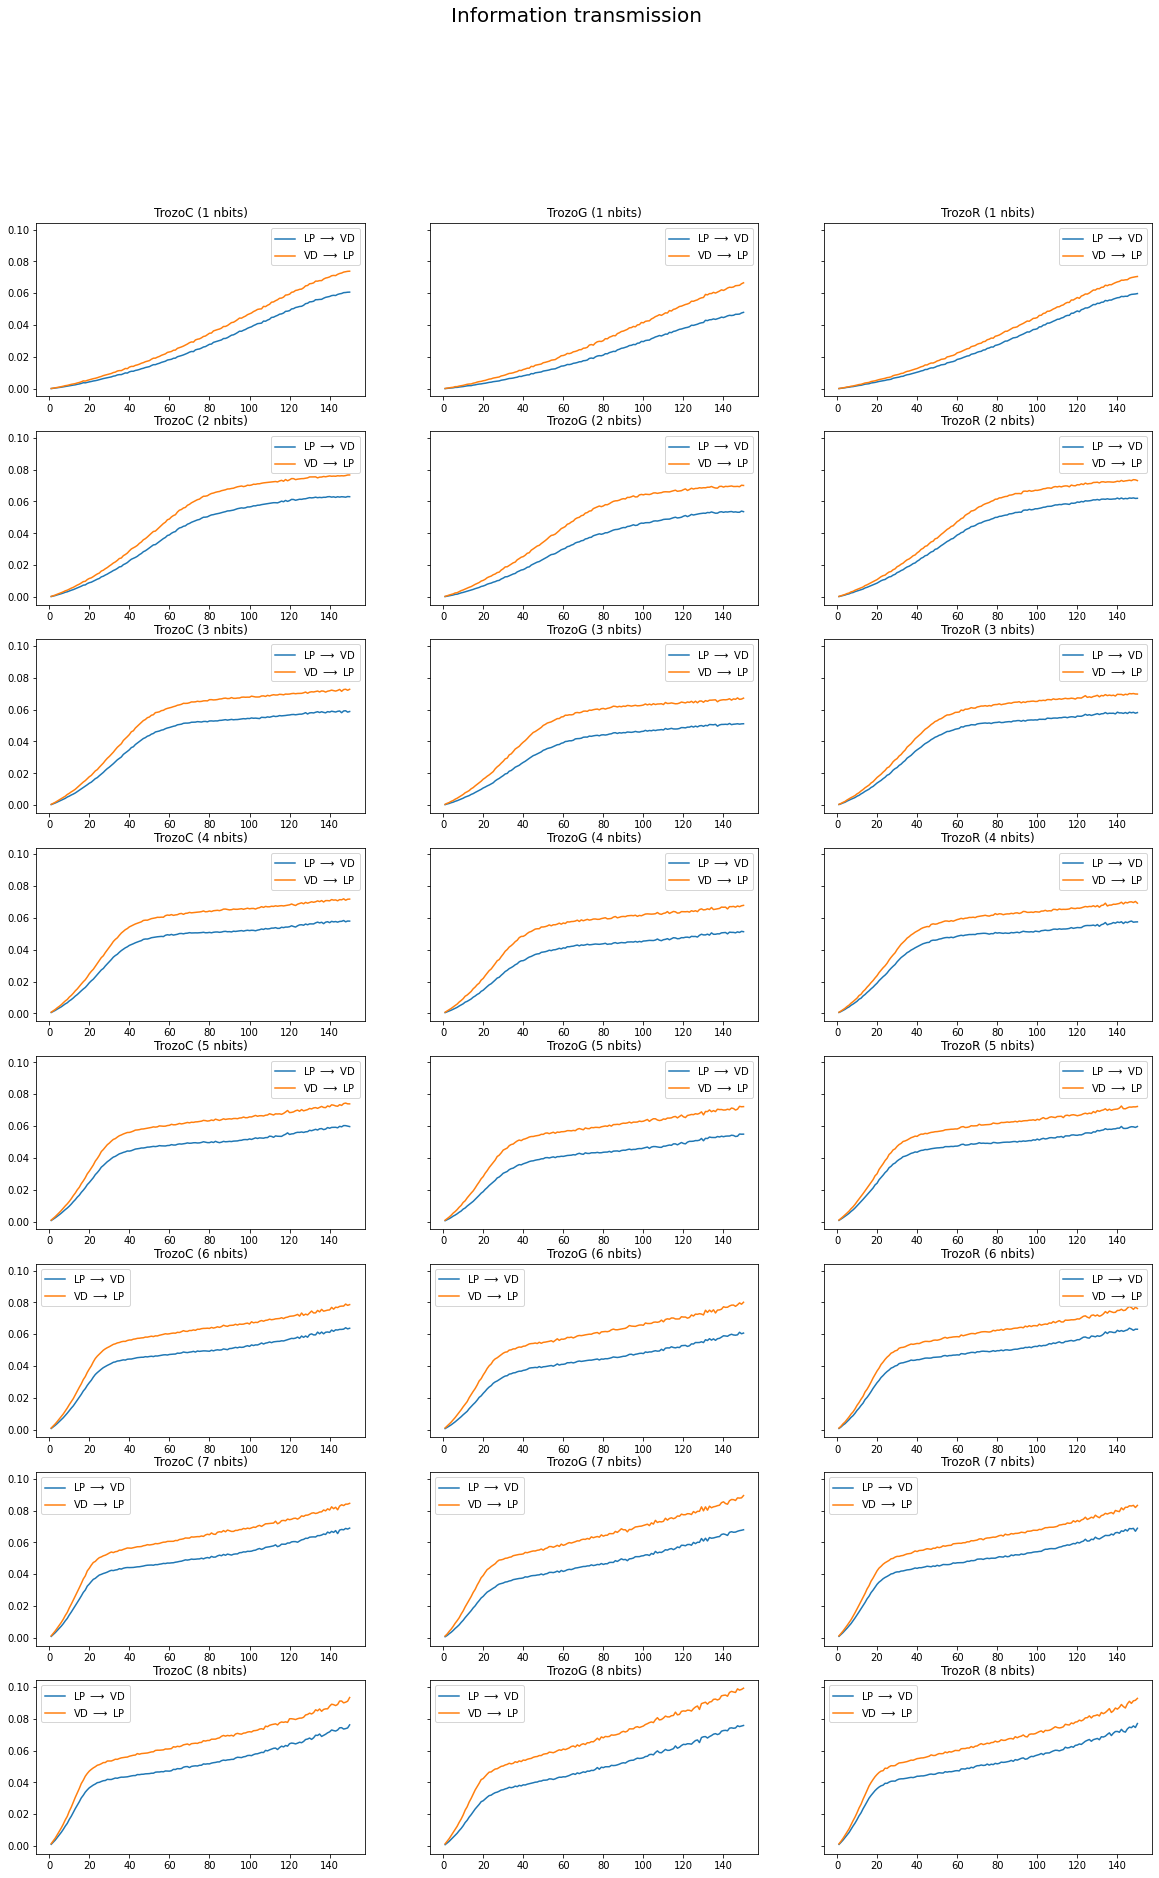

In [24]:
def plot_transfer_info(informationC,informationG,informationR, word_size, bin_size):
    """
        Plot transfer info for different bin size and by word size 
        Args:
            information_C (diccionary): Dict with mutual information
            information_G (diccionary): Dict with mutual information
            information_R (diccionary): Dict with mutual information 
            word_size ([int]): list of words size
            bin_size ([int]): list of bins size
    """
    fig, axes = plt.subplots(len(word_size), 3, figsize=(20, 30), sharey=True)
    plt.suptitle(f'Information transmission', fontsize=20)
    for nbits,row in enumerate(axes):
        row[0].plot(bin_size,informationC[nbits+1]['ti_lp_vd'],label=r'LP $\longrightarrow$ VD')
        row[0].plot(bin_size,informationC[nbits+1]['ti_vd_lp'],label=r'VD $\longrightarrow$ LP')
        row[0].set_title(f"TrozoC ({nbits+1} nbits)")
        row[0].legend()

        row[1].plot(bin_size,informationG[nbits+1]['ti_lp_vd'],label=r'LP $\longrightarrow$ VD')
        row[1].plot(bin_size,informationG[nbits+1]['ti_vd_lp'],label=r'VD $\longrightarrow$ LP')
        row[1].set_title(f"TrozoG ({nbits+1} nbits)")
        row[1].legend()

        row[2].plot(bin_size,informationR[nbits+1]['ti_lp_vd'],label=r'LP $\longrightarrow$ VD')
        row[2].plot(bin_size,informationR[nbits+1]['ti_vd_lp'],label=r'VD $\longrightarrow$ LP')
        row[2].set_title(f"TrozoR ({nbits+1} nbits)")
        row[2].legend()

    plt.show()
    
plot_transfer_info(information_C, information_G, information_R, word_size, bin_size)

#### Transmisión de información

Finalmente, se analiza la transmisión de información entre las dos neuronas LP y VD con el fin de detectar la neurona transmisora. 

Tras el análisis de la entropía, vimos que en todas las etapas la entropía era superior para la neurona LP, lo que nos indica que la tranmisión de información será mayor de la neruona VD a la neruona LP que viceversa. 

Analizando las gráficas, vemos que en todas las etapas la transmisión de información siguen los mismos patrones. Esto tiene sentido ya que todas las etapas están relacionadas. Además, destaca el cambio de pendiente en la transmisión de información cuando se utilizan tamaños de ventanas superiores. El momento que se produce el cambio de pendiente varía según el tamaño de palabra utilizado, siendo más notable cuando se utilizan palabras de 8 bits. Para este tamaño de palabras, el momento en que el varía la transmisión de información se produce al elegir ventanas superiores a 25. 

Finalmente, conviene comentar que la transferencia de información de la neurona LP a la neurona VD es menor cuando se inyecta GABA es menor en todos los casos. Esto puede indicar que la presencia de GABA reduce la influencia de la neurona LP en la neurona VD.

### 3.5.2. Utilizando palabras deslizantes

A continuación estudiaremos la transferencia de información, la información mutua y la entropía cuando utilizamos palabras solapadas o deslizantes, en lugar palabras fijas.

In [25]:
word_size = range(1,9)
information_C = compute_information(word_size, bin_size, lp_bins_C, vd_bins_C, False)

In [27]:
information_G = compute_information(word_size, bin_size, lp_bins_G, vd_bins_G, False)

In [28]:
information_R = compute_information(word_size, bin_size, lp_bins_R, vd_bins_R, False)

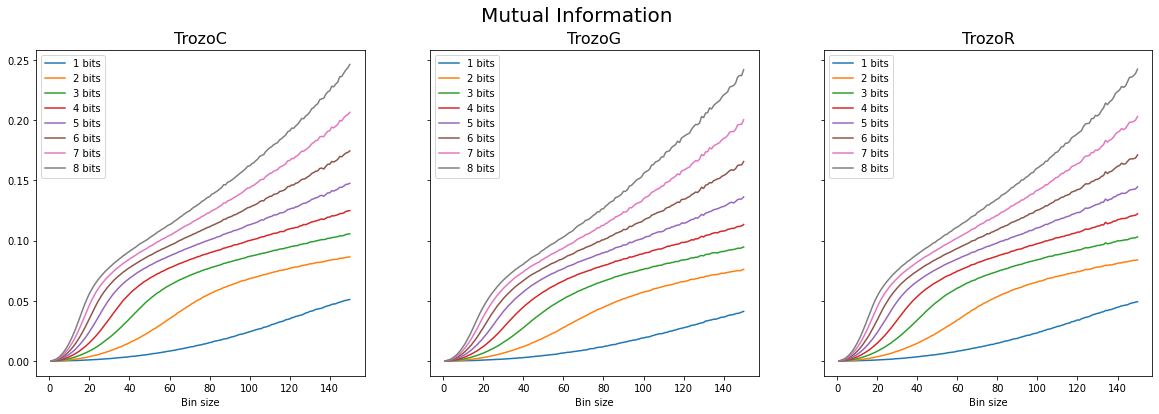

In [29]:
plot_mutual_information(information_C, information_G, information_R, word_size, bin_size)

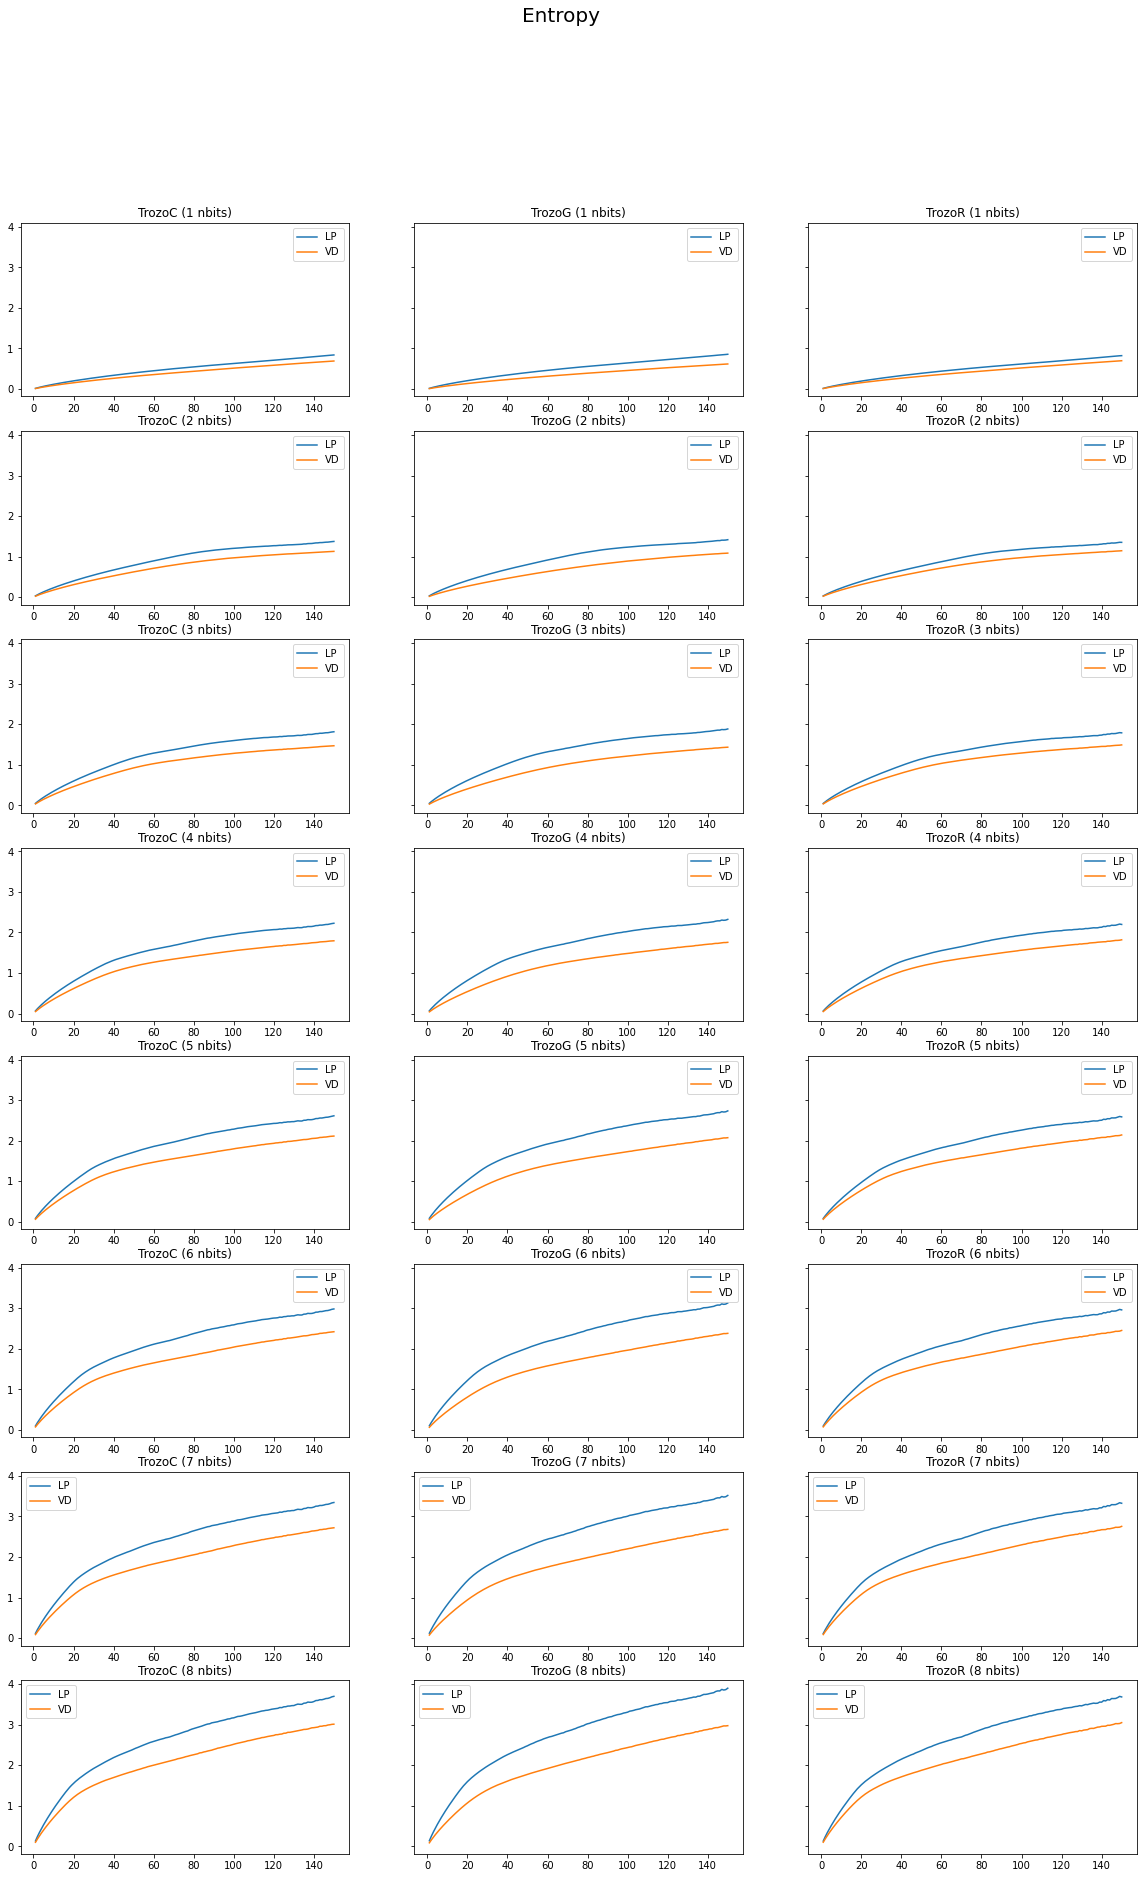

In [30]:
plot_entropia(information_C, information_G, information_R, word_size, bin_size)

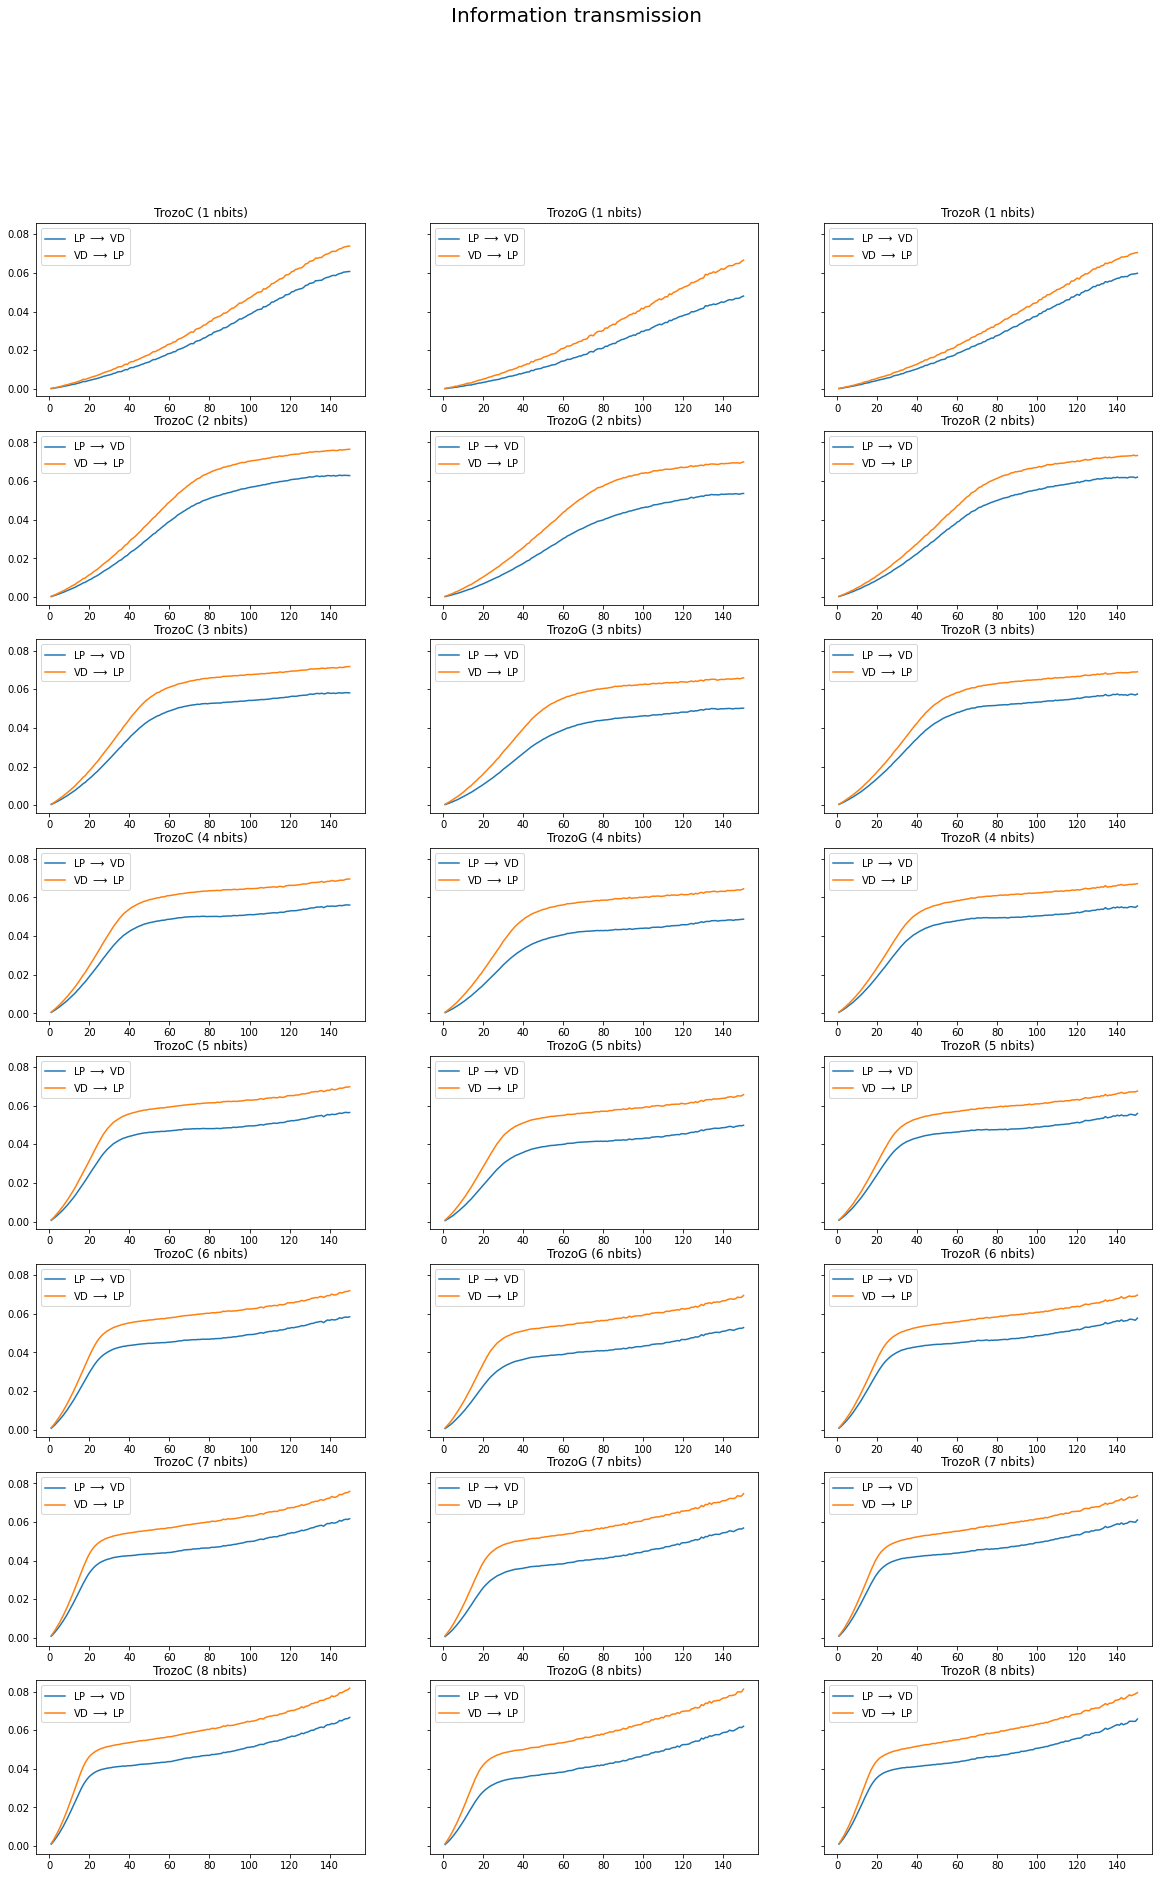

In [31]:
plot_transfer_info(information_C, information_G, information_R, word_size, bin_size)

Puede realizarse un análisis similar al anterior. De nuevo, la información mutua aumenta al aumentar el tamaño de ventanas y es superior para palabras de 8 bits. La única diferencia es que en este caso, la variación de la información mutua es más suave y tiene un valor igual a 0.25. Recordemos que cuando se utilizaban palabras fijas llegaba hasta 0.3. Para la entropía y la transmisión de información apenas se aprecian diferencias respecto al análisis anterior.

# 4. Análisis de los datos a través de Bursts

En lugar de utilizar los spikes como eventos a analizar, en esta nueva codificación vamos a utilizar bursts, que son agrupaciones de spikes cercanos en el tiempo. De esta manera, los eventos de interés serán sucesiones de spikes.

Si recordamos la gráfica que ilustraba las señales de las neuronas LP y VD a partir del instante 50000 de tiempo, se observan agrupaciones de spikes cada 3000 instantes de tiempo aproximadamente. Por ese motivo, buscaremos eventos cuya distancia entre eventos sea igual o mayor a 3000.  

## 4.2. Detección de Bursts

________________ TrozoC ________________
Total events (LP): 2460
Total events (VD): 2105
________________ TrozoG ________________
Total events (LP): 2295
Total events (VD): 1934
________________ TrozoR ________________
Total events (LP): 2036
Total events (VD): 1738


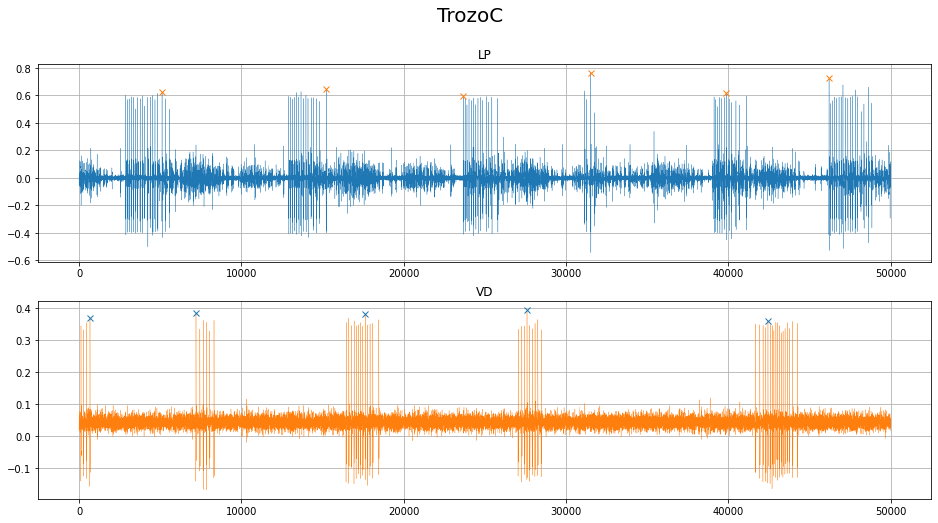

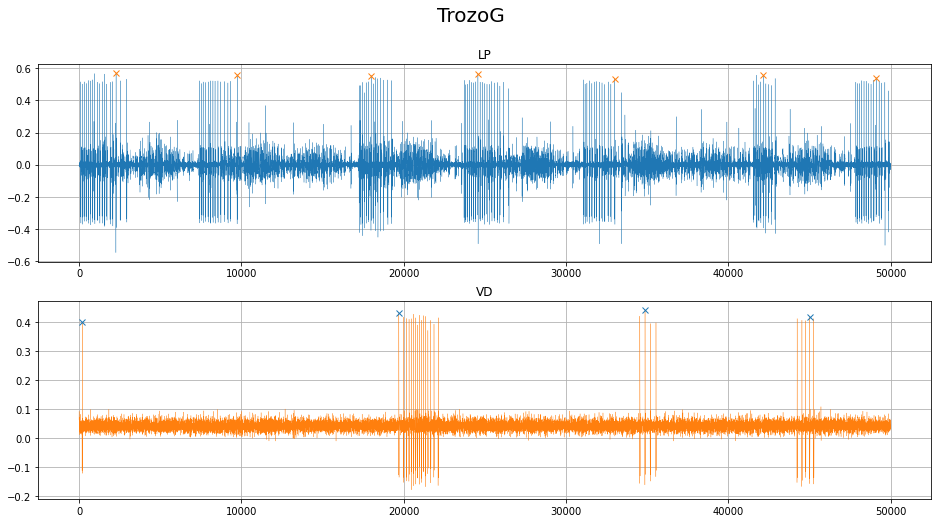

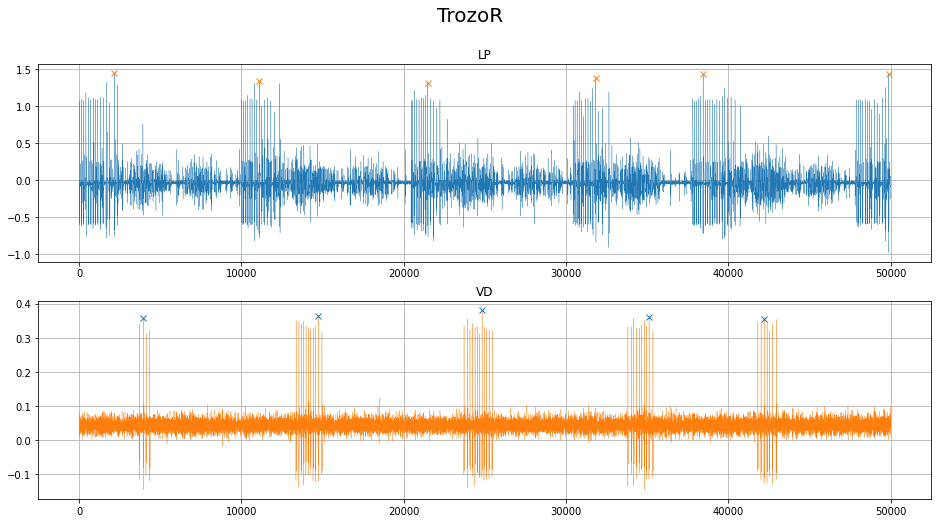

In [21]:
lp_bursts_C, vd_bursts_C = find_events(trozoC,'TrozoC', thresholdC, 3000)
lp_bursts_G, vd_bursts_G = find_events(trozoG,'TrozoG', thresholdG, 3000)
lp_bursts_R, vd_bursts_R = find_events(trozoR,'TrozoR', thresholdR, 3000)

Al igual que en el análisis de las neuronas utilizando spikes, vamos a tratar de entender la distribución de los bursts observando las distancia entre estos. 

________________ TrozoC ________________
________ LP ________
Min: 3003
Max: 25385
Mean: 8048.514987714988
Medium: 8007.0
Q1: 3003.5085
________ VD ________
Min: 3000
Max: 32748
Mean: 9429.185836501902
Medium: 9125.5
Q1: 3000.52575
________________ TrozoG ________________
________ LP ________
Min: 3005
Max: 16114
Mean: 7137.610723626853
Medium: 7015.0
Q1: 3014.74525
________ VD ________
Min: 3010
Max: 23574
Mean: 8472.562338334195
Medium: 8002.0
Q1: 3010.9660000000003
________________ TrozoR ________________
________ LP ________
Min: 3003
Max: 25385
Mean: 8048.514987714988
Medium: 8007.0
Q1: 3003.5085
________ VD ________
Min: 3000
Max: 32748
Mean: 9429.727691421991
Medium: 9102.0
Q1: 3000.434


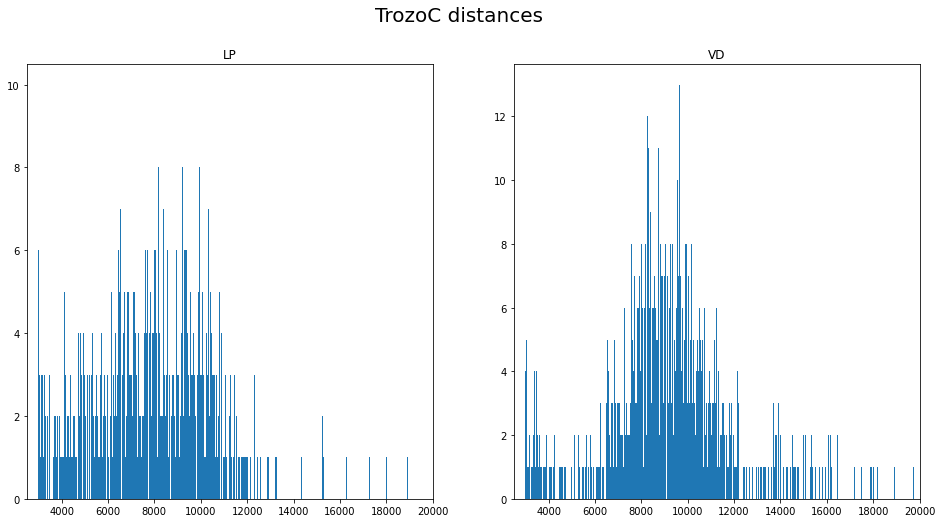

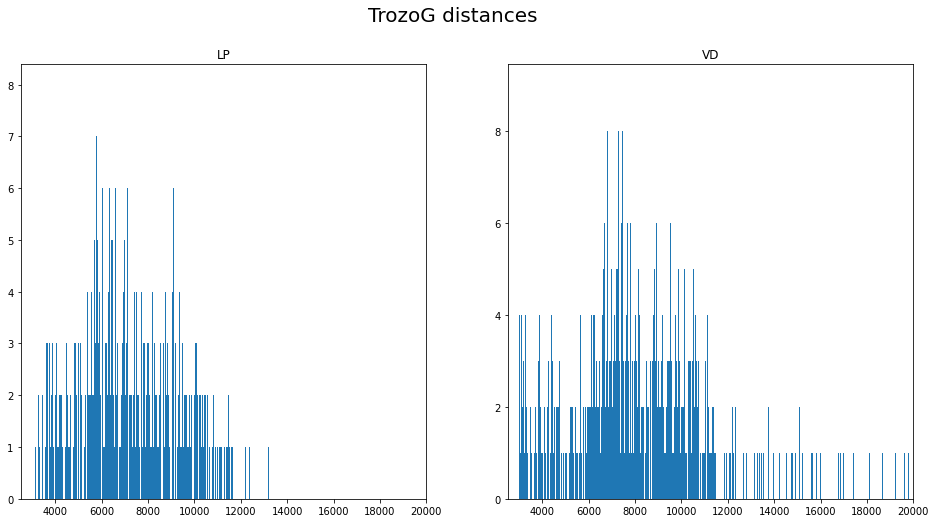

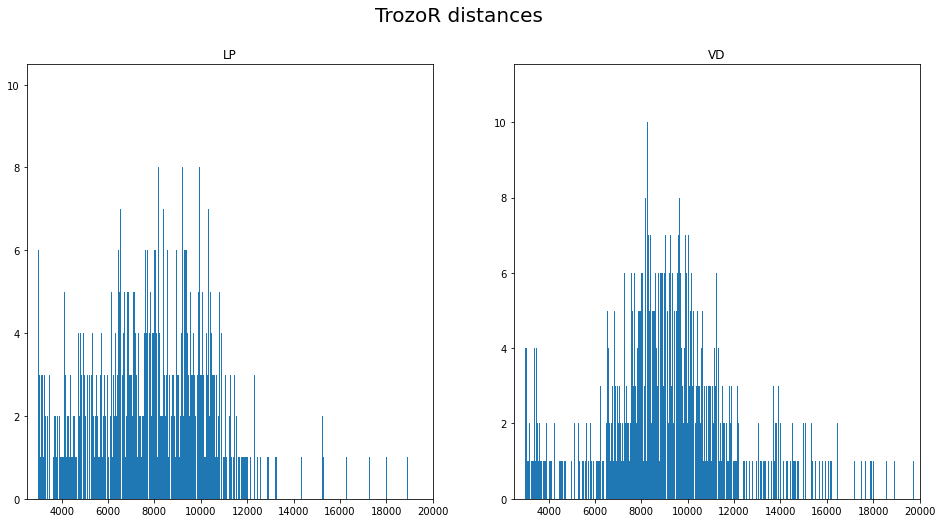

In [22]:
distances_b_events('TrozoC', lp_bursts_R, vd_bursts_C, 2500, 20000)
distances_b_events('TrozoG', lp_bursts_G, vd_bursts_G, 2500, 20000)
distances_b_events('TrozoR', lp_bursts_R, vd_bursts_R, 2500, 20000)

La distancia más habitual entre bursts está entre los 8000 y los 9500. Por tanto, nuestro análisis de transmisión de información deberá focalizarse en aquellos bursts cuya distancia no supere estos valores, ya que a partir de ese momento, la tasa de error aumentará.

## 4.3. Codificación

Se realiza la misma codificación utilizada para el análisis de los spikes (**discretize_by_bursts**) y se muestra el resultado de la codificación (**show_discretize_burst**).

In [23]:
def show_discretize_burst(chunk, name, n):
    """
        Show the first n binary encoding for bursts (burst = 1, other = 0)
        Args:
            chunk (Dataframe): chunk to analyze
            name (str): name of chunk to analyze
            n (int): n records to show

    """
    
    fig, (ax1, ax2) = plt.subplots(2, 1)
    fig.set_size_inches(16, 8)
    plt.suptitle('Discretize {0}'.format(name), fontsize=20)
    ax1.plot(chunk[f'LP_bursts'].iloc[:n],lw=0.6, label = 'LP')
    ax1.plot(chunk[f'VD_bursts'].iloc[:n],'tab:orange',lw=0.6, label='VD')
    
    ax2.plot(chunk[f'LP'].iloc[:n],lw=0.6, label = 'LP')
    ax2.plot(chunk[f'VD'].iloc[:n],'tab:orange',lw=0.6, label='VD')


def discretize_by_bursts(chunk, lp_bursts, vd_bursts):
    """
        Binary encoding for bursts (burst = 1, other = 0)
        Args:
            chunk (Dataframe): chunk to analyze
            lp_bursts (numpy): index of lp bursts found
            vd_bursts (numpy): index of vd bursts found

    """

    chunk['LP_bursts'] = 0
    chunk.loc[lp_bursts, 'LP_bursts'] = 1
    chunk['VD_bursts'] = 0
    chunk.loc[vd_bursts, 'VD_bursts'] = 1
    return chunk

In [24]:
trozoC = discretize_by_bursts(trozoC, lp_bursts_C, vd_bursts_C)
trozoG = discretize_by_bursts(trozoG, lp_bursts_G, vd_bursts_G)
trozoR = discretize_by_bursts(trozoR, lp_bursts_R, vd_bursts_R)

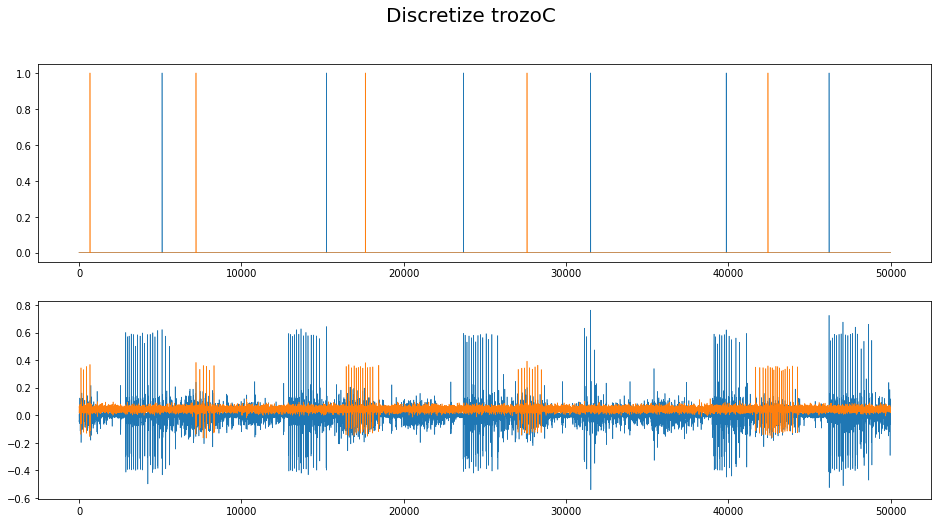

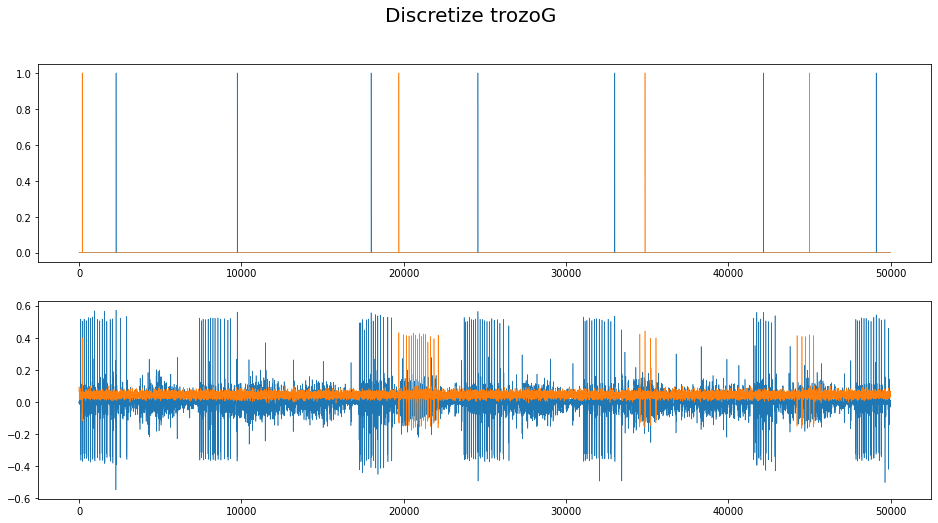

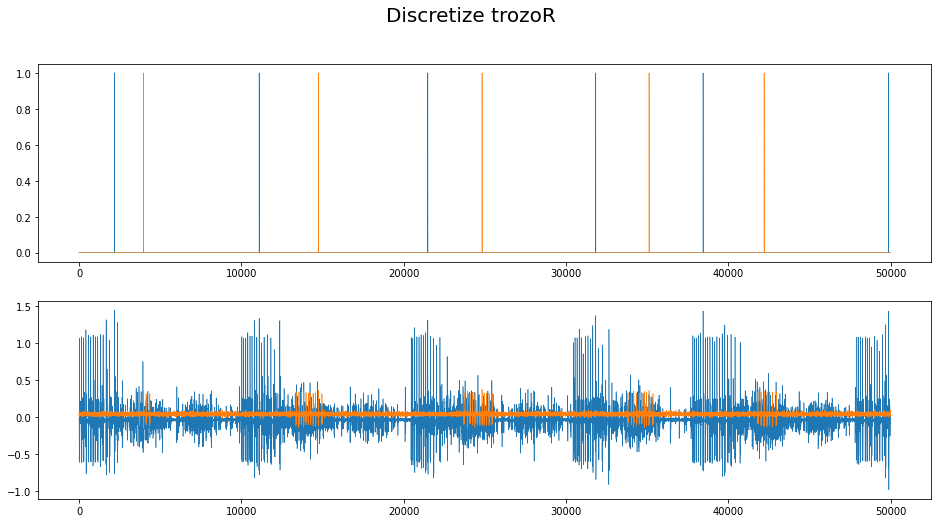

In [17]:
show_discretize_burst(trozoC, 'trozoC', 50000)
show_discretize_burst(trozoG, 'trozoG', 50000)
show_discretize_burst(trozoR, 'trozoR', 50000)

## 4.4. Tasa de error por tamaño de ventana

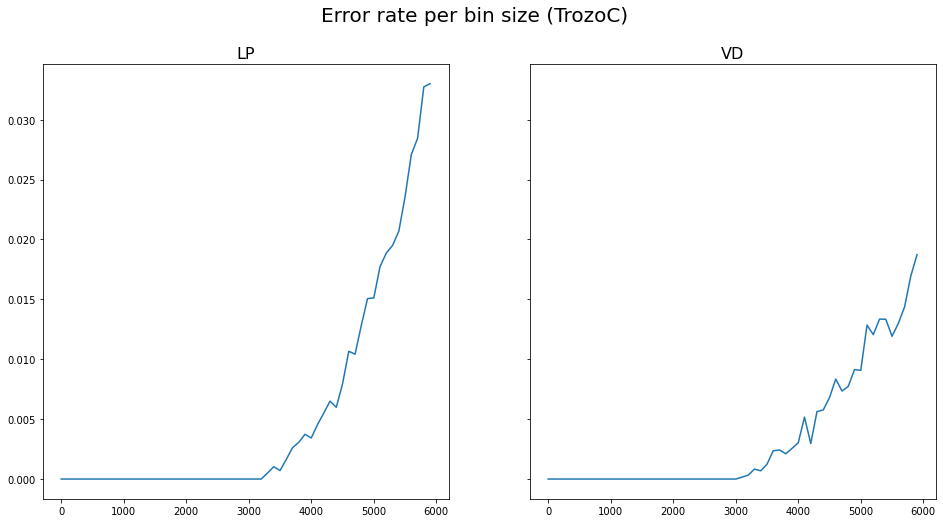

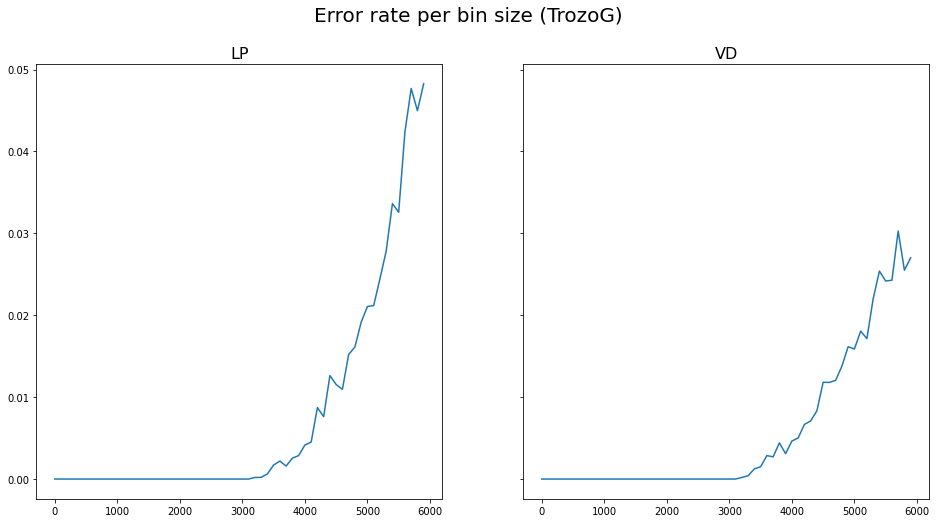

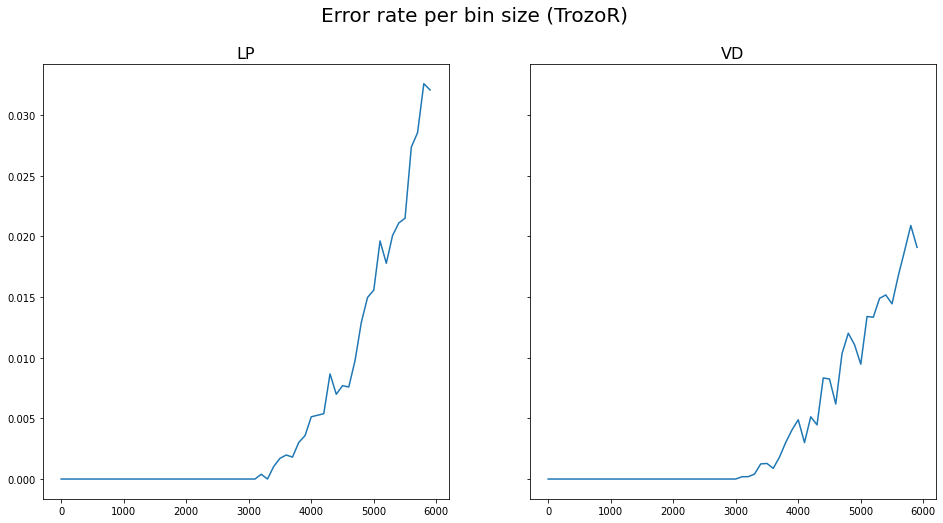

In [25]:
lp_errors_C, vd_errors_C = get_errors_rate_per_neuron(trozoC, 'bursts', 'TrozoC', range(1, 6000, 100))
lp_errors_G, vd_errors_G = get_errors_rate_per_neuron(trozoG, 'bursts', 'TrozoG', range(1, 6000, 100))
lp_errors_R, vd_errors_R = get_errors_rate_per_neuron(trozoR, 'bursts', 'TrozoR', range(1, 6000, 100))

Para tamaños de ventana fijos, en todas las etapas, las neuronas LP y VD comienzan a presentar un mayor número de errores (presentan más de un burst por ventana) cuando se utilizan tamaños aproximadamente superiores a 5000. El error obtenido al aumentar el tamaño por encima de 5000 es mayor que el 1%..

## 4.5. Cálculo de la entropía y la información mutua

Para realizar el análisis de la transmisión de información entre neuronas al utilizar los bursts como eventos de información, se va a estudiar cómo varía según el tamaño de ventana esta tranmisión, la entropía y la información mutua cuando se utilizan tamaños de ventana desde 1 hasta 6000, utilizando saltos iguales a 100 para no abusar del coste computacional que esto supondría. Al igual que en el análisis anterior, se van a estudiar estas medidas de información para cada tamaño de palabra, desde 1 bit hasta 8 bits.

In [26]:
bin_size = range(1, 6000, 100)

lp_bins_C, vd_bins_C = compute_signal_by_bins(bin_size, chunk = trozoC, coding = 'bursts')
lp_bins_G, vd_bins_G = compute_signal_by_bins(bin_size, chunk = trozoG, coding = 'bursts')
lp_bins_R, vd_bins_R = compute_signal_by_bins(bin_size, chunk = trozoR, coding = 'bursts')

### 4.5.1. Utilizando palabras fijas

In [27]:
word_size = range(1,9)
information_C = compute_information(word_size, bin_size, lp_bins_C, vd_bins_C, True)
information_G = compute_information(word_size, bin_size, lp_bins_G, vd_bins_G, True)
information_R = compute_information(word_size, bin_size, lp_bins_R, vd_bins_R, True)

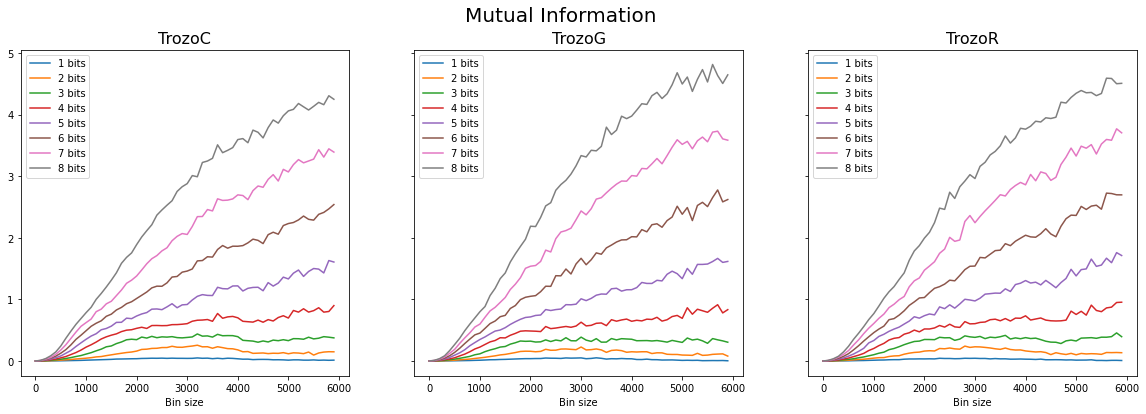

In [28]:
plot_mutual_information(information_C, information_G, information_R, word_size, bin_size)

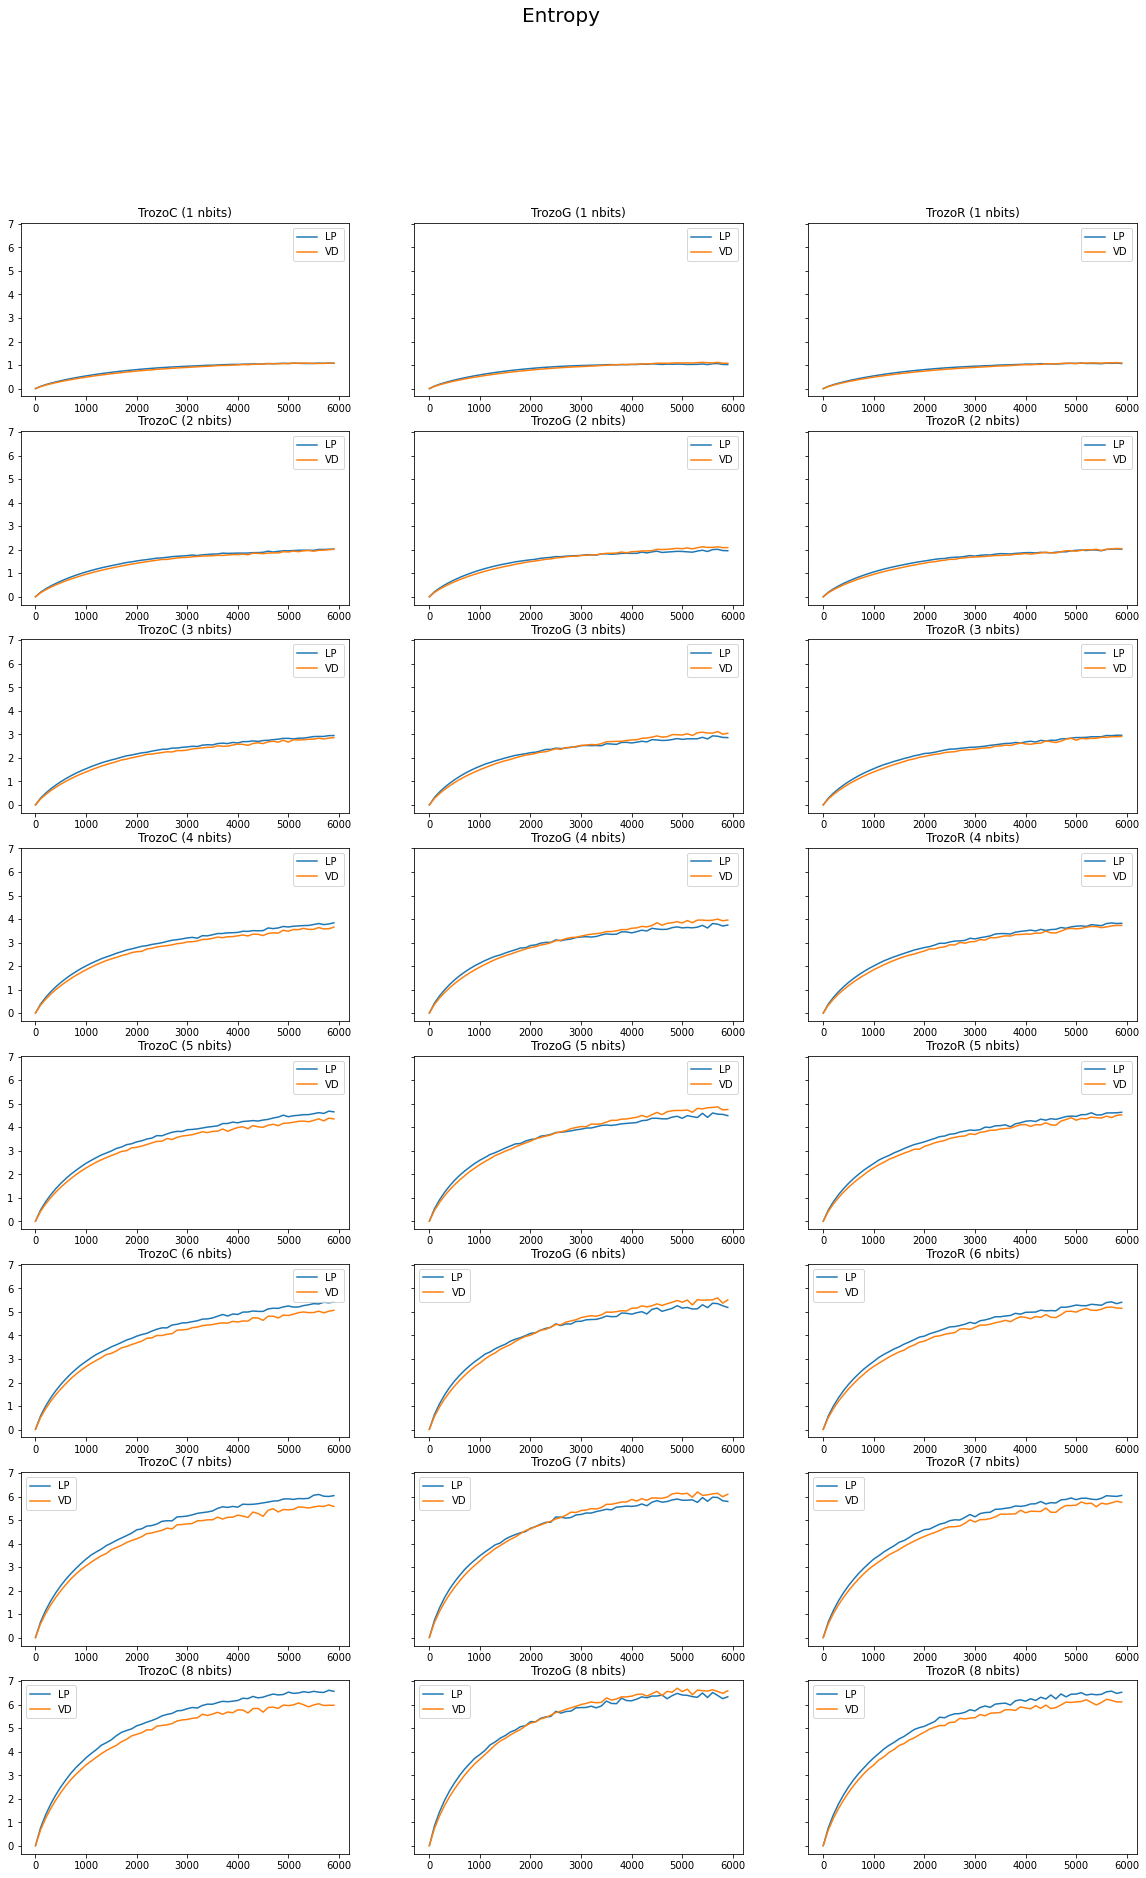

In [29]:
plot_entropia(information_C, information_G, information_R, word_size, bin_size)

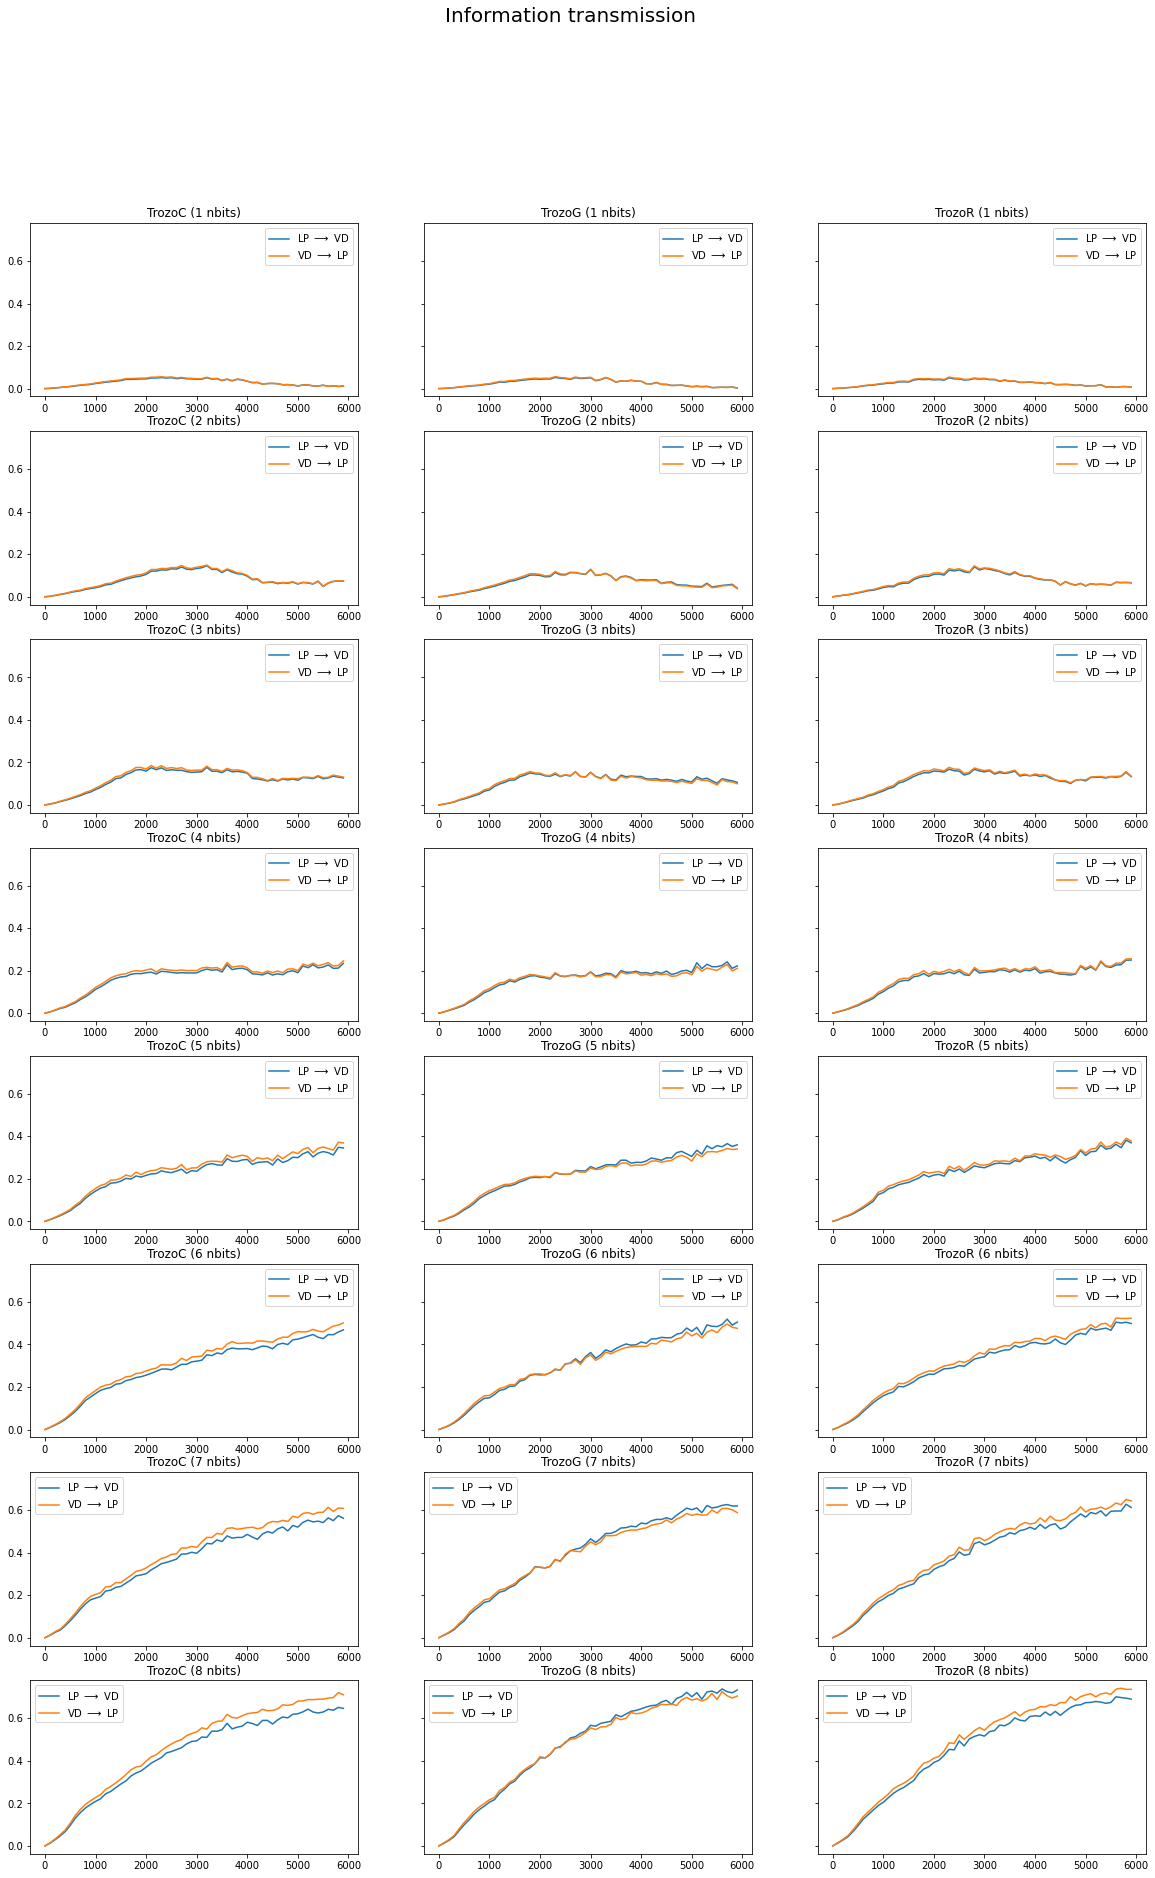

In [33]:
plot_transfer_info(information_C, information_G, information_R, word_size, bin_size)

Utilizando esta codificación, vemos que la entropía de ambas neuronas es superior a la obtenida utilizando spikes. Esto implica que la tranferencia de información será mayor al utilizar bursts. De hecho, comparando la tranferencia de información con la codificación basada en spikes, vemos que es aproximadamente 6 veces superior, llegando a valores de 0.6 para tamaños de palabras de 8 bits y tamaños de ventana de 5000. Esto implica que la codificación basada en bursts se asemeja más a la codificación real del sistema biológico.
Además, para esta codificación la tranferencia de información de la neurona VD a LP es superior a la transmisión de información de la neurona LP a VD, al igual que ocurría en el análisis de spikes. Sin embargo, en la etapa de inyección de GABA, la transferencia de ambas neuronas está muy igualadas y no se aprecía la neurona dominante.  

### 4.5.2 Utilizando palabras deslizantes

In [34]:
word_size = range(1,9)
information_C = compute_information(word_size, bin_size, lp_bins_C, vd_bins_C, False)
information_G = compute_information(word_size, bin_size, lp_bins_G, vd_bins_G, False)
information_R = compute_information(word_size, bin_size, lp_bins_R, vd_bins_R, False)

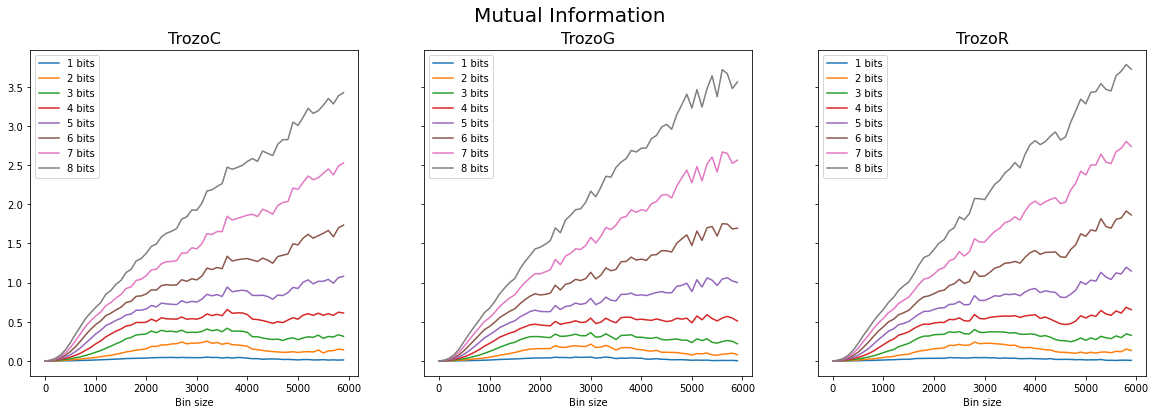

In [35]:
plot_mutual_information(information_C, information_G, information_R, word_size, bin_size)

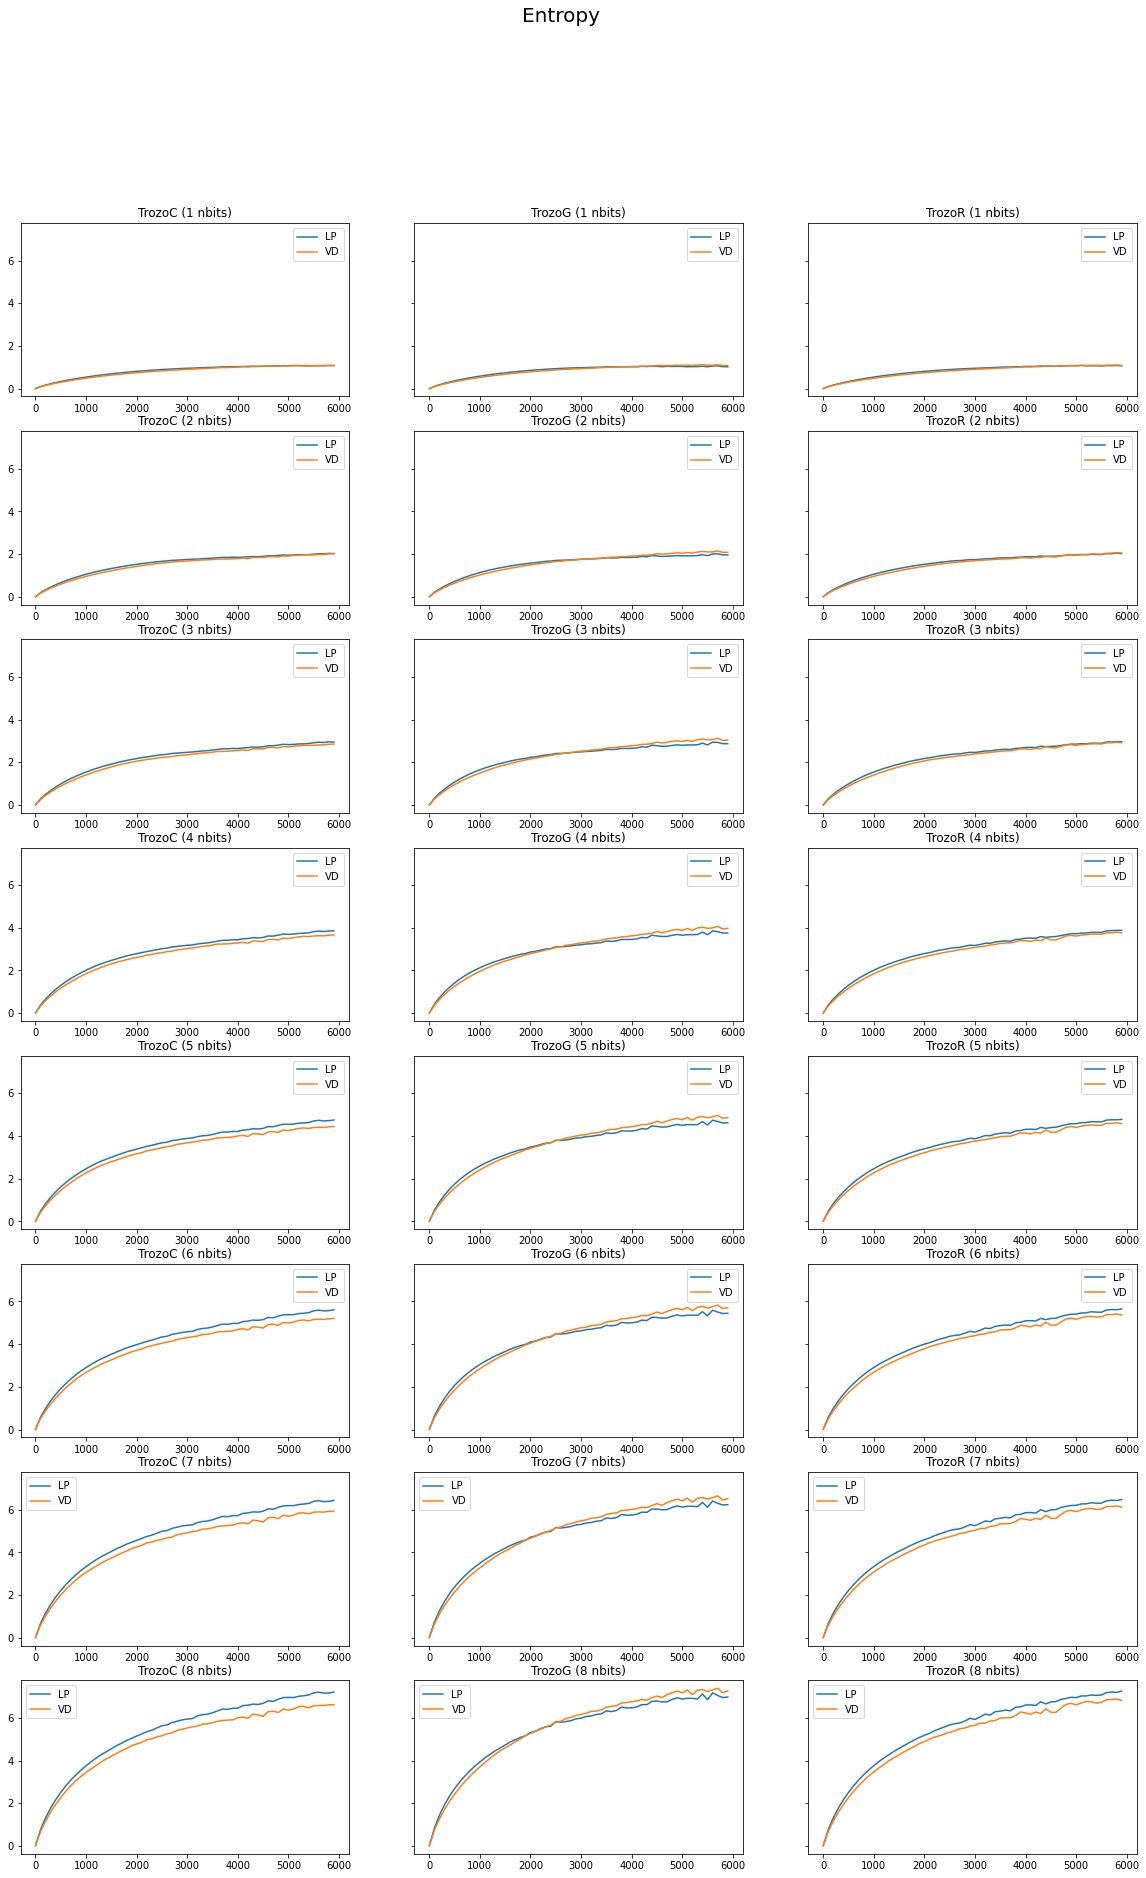

In [36]:
plot_entropia(information_C, information_G, information_R, word_size, bin_size)

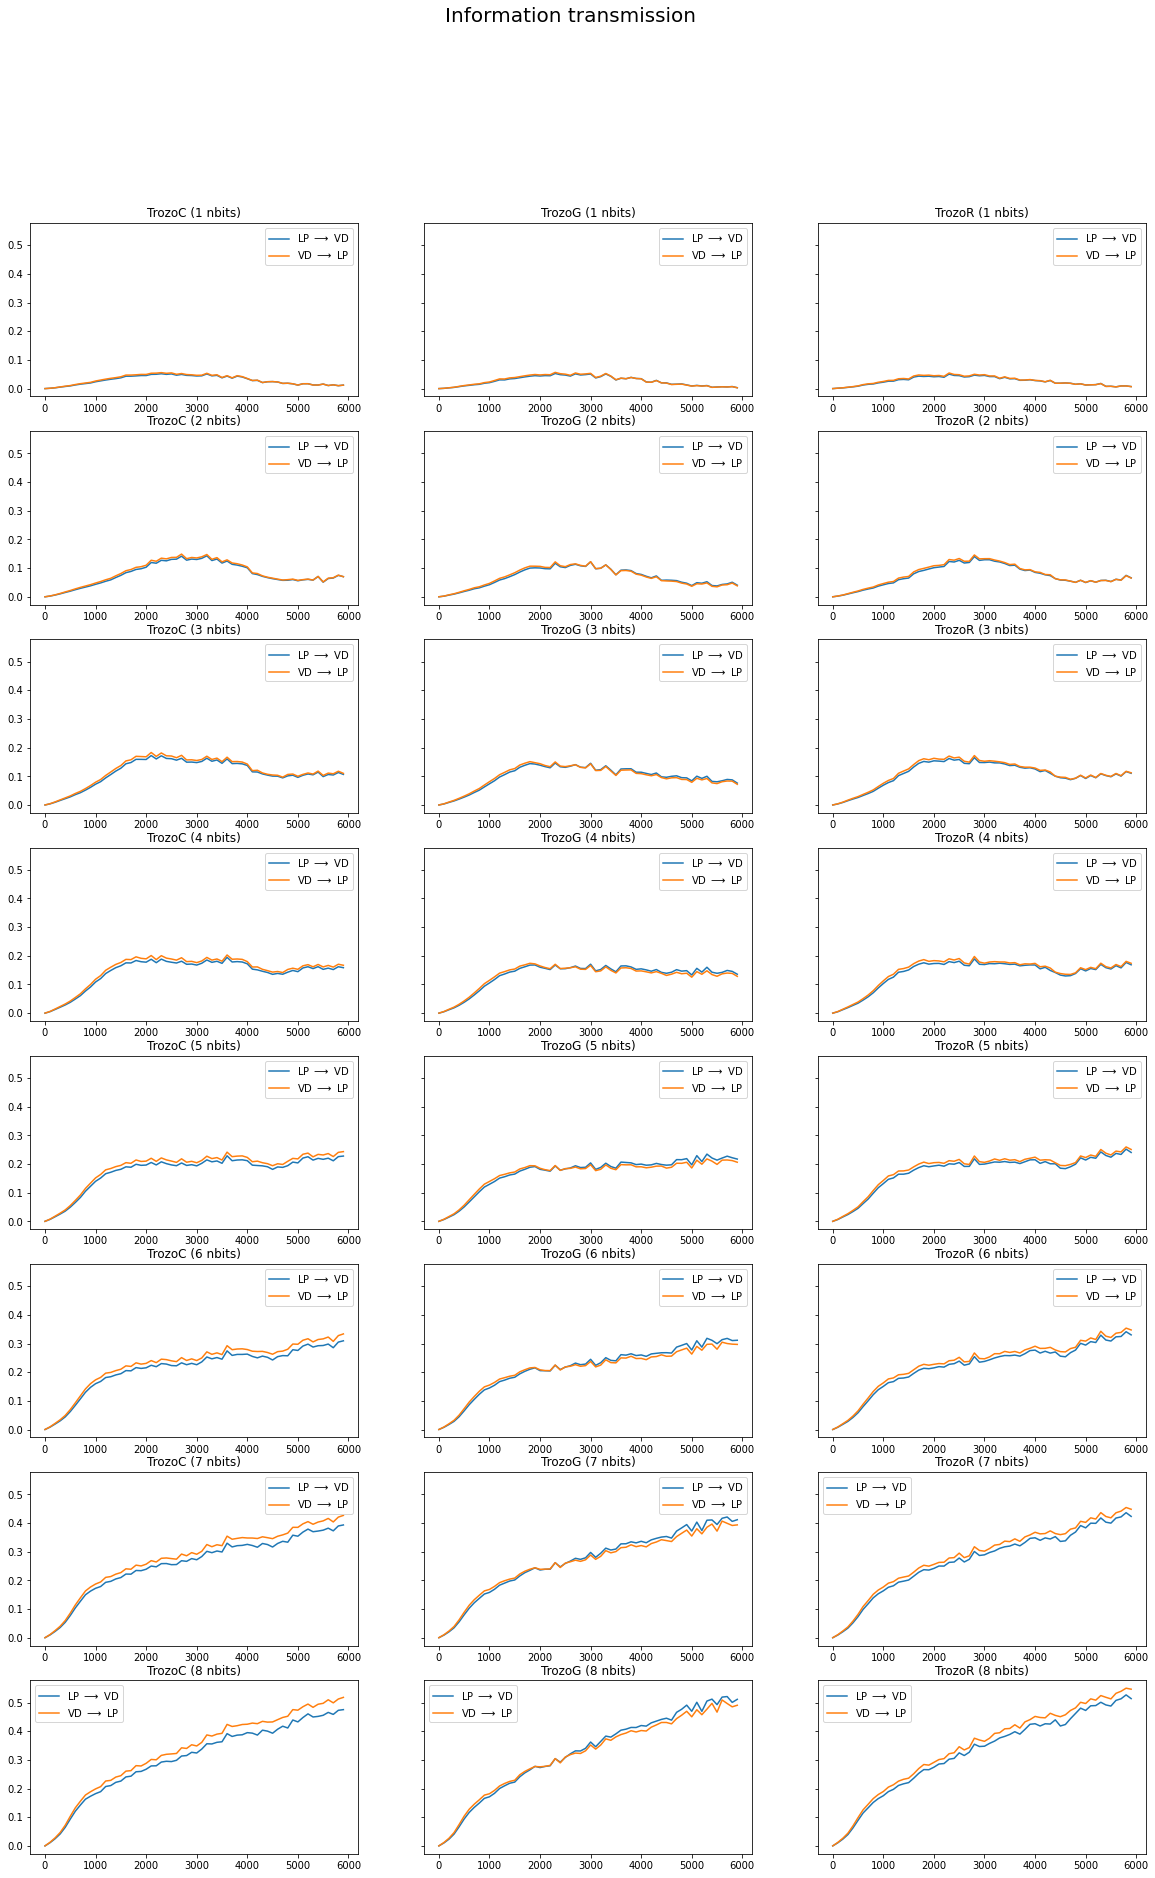

In [37]:
plot_transfer_info(information_C, information_G, information_R, word_size, bin_size)

Un análisis similar al realizado para palabras fijas puede realizarse para palabras deslizantes, ya que apenas de aprecian diferencias.

## 5. Conclusiones

Tras un estudio de las técnicas de Teoría de la Información para entender los fenómenos que suceden dentro de un sistema biológico real, concluimos que la neurona LP influye sobre la neurona VD en la transferencia de información. Además, dado que el GABA es un neurotransmisor inhibidor, se ha comprobado que el comportamiento del sistema es similar a lo que esperaríamos. Además, se ha probado cómo cambiar el sistema de codificación produce resultados diferentes a la hora de analizar una serie temporal, siendo para este caso, más acertada la elección de una codificación basada en bursts.